# [MARKETING ANALYTICS] Modeling - Supervised Classification


**OBJETIVO DO PROJETO:**

O principal objetivo deste projeto é aumentar a eficácia das campanhas de marketing do banco.

**PREMISSAS:**

1. A análise considera apenas pessoas físicas, excluindo contas corporativas ou jurídicas.
2. Apenas clientes contactados durante a campanha mais recente são incluídos na análise, excluindo dados de campanhas anteriores.
3. Consideram-se apenas os contatos feitos via telefone celular e telefone fixo, excluindo outros meios de contato.


**FONTES INFORMACIONAIS:**

1. Dados das campanhas de marketing direto realizadas pelo banco, disponíveis no Bank Marketing Dataset da UCI Machine Learning Repository.
2. Indicadores econômicos, como taxa de variação de emprego, índice de preços ao consumidor, índice de confiança do consumidor e taxa Euribor de 3 meses.



**OBJETIVO(S) DO SCRIPT:**

Desenvolver um modelo preditivo para identificar leads com maior propensão a converter, utilizando variáveis como histórico de campanhas, idade, ocupação e método de contato preferido. Este modelo pode ser integrado ao CRM para priorizar esforços de venda e marketing.

O trabalho está seguindo a metodologia CRISP-DM e este script corresponde a fase de Modeling.


**MODELOS A SEREM UTILIZADOS:**

1. Logistic Regression
1. K-Nearest Neighbors
1. Decision Tree
1. Random Forest
1. XGBoost
1. Multi Layer Perceptron Neural Network


**CENÁRIOS DE TESTE:**
1. BALANCEAMENTO: Treinamento de todos os modelos com hiperparâmetros padrão no conjunto de dados original após balanceamento com diferentes técnicas.
  - OBJETIVO: Encontrar o balanceamento mais adequado aos dados.
1. VARIÁVEIS ORIGINAIS VS DERIVADAS: Treinamento de todos os modelos com os hiperparâmetros padrão no conjunto de dados original vs o conjunto de dados com variáveis derivadas usando o balanceamento definido anteriormente.
  - OBJETIVO: Encontrar o melhor conjunto de dados a ser utilizado como ponto de partida.
1. REDUÇÃO DE DIMENSIONALIDADE: Treinamento de todos os modelos com hiperparâmetros padrão no conjunto de dados e balanceamento selecionados anteriormente utilizando técnicas de feature selection e PCA.
  - OBJETIVO: Verificar se e qual a técnica de redução de dimensionalidade melhora o desempenho do modelo preditivo.


**CRITÉRIOS DE AVALIAÇÃO:**

Para comparar a performance dos modelos, utilizaremos as seguintes métricas de avaliação em ordem de importância:

1. F1-Score: Média harmônica entre precisão e recall.
1. ROC AUC (Área sob a Curva ROC): Medida da capacidade do modelo em distinguir entre as classes.
1. Explicabilidade: Quão fácil é explicar os resultados do modelo em algumas regras de negócio?
1. Precision (Precisão): Proporção de verdadeiros positivos em relação ao total de previsões positivas.
1. Recall (Sensibilidade): Proporção de verdadeiros positivos em relação ao total de positivos reais.
1. Acurácia: Proporção de previsões corretas em relação ao total de previsões.

Considerando que:

 - F1 Score é crucial porque balanceia precisão e sensibilidade, permitindo identificar de forma equilibrada clientes que converterão, sem inflar falsamente os números de conversão.
 - AUC-ROC é importante porque um bom desempenho nesta métrica assegura que o modelo está distinguindo bem entre os clientes que converterão e os que não converterão, o que é vital para a tomada de decisões estratégicas de marketing e para a alocação eficiente de recursos.
 - Explicabilidade é essencial para garantir que os modelos de previsão de conversão sejam não apenas precisos, mas também transparentes e justos. Ela aumenta a confiança, melhora a alocação de recursos, facilita a conformidade regulamentar e ajuda a identificar e mitigar vieses. Em última análise, um modelo explicável promove uma abordagem mais estratégica e ética em campanhas de marketing, resultando em melhores resultados físicos e financeiros.
 - Precisão é relevante porque, em marketing, alocar recursos para clientes que não converterão pode ser muito dispendioso.
 - Sensibilidade é relevante porque, para maximizar as conversões, é importante identificar o maior número possível de clientes que converterão.
 - Acurácia é a menos importante devido ao desequilíbrio das classes, o que pode fazer com que essa métrica seja menos representativa da performance real do modelo em identificar conversões.


## 1. BIBLIOTECAS E CONFIGURAÇÕES



### 1.1 BIBLIOTECAS

In [123]:
import warnings
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)

from sklearn.utils.validation import column_or_1d
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel, RFE

from imblearn.over_sampling import RandomOverSampler, SMOTENC, ADASYN, KMeansSMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.cluster import MiniBatchKMeans

### 1.2 CONFIGURAÇÕES

In [124]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings('ignore')

### 1.3 FUNÇÕES

In [125]:
def evaluate_models(x_train, x_test, x_val, y_train, y_test, y_val, models):
    """
    Avalia os modelos fornecidos com as métricas especificadas e exibe as matrizes de confusão normalizadas.

    Parâmetros:
    x_train (pd.DataFrame): Dados de treinamento.
    x_test (pd.DataFrame): Dados de teste.
    x_val (pd.DataFrame): Dados de validação.
    y_train (pd.Series): Rótulos de treinamento.
    y_test (pd.Series): Rótulos de teste.
    y_val (pd.Series): Rótulos de validação.
    models (dict): Dicionário com os modelos do sklearn para avaliação.

    Retorna:
    pd.DataFrame: DataFrame com as métricas de desempenho dos modelos.
    """

    # Garantir que os rótulos estejam na forma correta
    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)
    y_val = np.ravel(y_val)

    results = []

    for name, model in models.items():
        start_time = time.time()

        # Treinamento do modelo
        model.fit(x_train, y_train)
        training_time = time.time() - start_time

        # Previsões
        y_train_pred = model.predict(x_train)
        y_test_pred = model.predict(x_test)
        y_val_pred = model.predict(x_val)

        # Cálculo das métricas
        metrics = {
            'Model': name,
            'Training Time (s)': training_time,
            'Train Accuracy': accuracy_score(y_train, y_train_pred),
            'Test Accuracy': accuracy_score(y_test, y_test_pred),
            'Val Accuracy': accuracy_score(y_val, y_val_pred),
            'Train F1': f1_score(y_train, y_train_pred),
            'Test F1': f1_score(y_test, y_test_pred),
            'Val F1': f1_score(y_val, y_val_pred),
            'Train AUC': roc_auc_score(y_train, y_train_pred),
            'Test AUC': roc_auc_score(y_test, y_test_pred),
            'Val AUC': roc_auc_score(y_val, y_val_pred),
            'Train Precision': precision_score(y_train, y_train_pred),
            'Test Precision': precision_score(y_test, y_test_pred),
            'Val Precision': precision_score(y_val, y_val_pred),
            'Train Recall': recall_score(y_train, y_train_pred),
            'Test Recall': recall_score(y_test, y_test_pred),
            'Val Recall': recall_score(y_val, y_val_pred)
        }

        results.append(metrics)

        # Plotando as matrizes de confusão normalizadas
        fig, axes = plt.subplots(1, 3, figsize=(12, 3))
        fig.suptitle(f'Confusion Matrix for {name}')
        fig.subplots_adjust(top=0.85)

        for ax, data, title in zip(
            axes,
            [(y_train, y_train_pred, 'Train'),
             (y_test, y_test_pred, 'Test'),
             (y_val, y_val_pred, 'Validation')],
            ['Train', 'Test', 'Validation']
        ):
            cm = confusion_matrix(data[0], data[1], normalize='true')
            sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", cbar=False, ax=ax)
            ax.set_title(f'{title} Confusion Matrix')
            ax.set_xlabel('Predicted Label')
            ax.set_ylabel('True Label')

        plt.show()

    # Criação do DataFrame de resultados
    results_df = pd.DataFrame(results)

    return results_df

In [126]:

def calculate_and_display_metrics(dummy_clf, X_train, y_train, X_test, y_test, X_val, y_val):
    """
    Calcula métricas (ROC AUC, F1 Score, Precision, Recall, Accuracy) e exibe matrizes de confusão
    para treino, teste e validação usando um Dummy Classifier.

    Parâmetros:
    - dummy_clf (objeto): Instância do Dummy Classifier já ajustado aos dados de treino.
    - X_train, y_train (array-like): Dados de treino.
    - X_test, y_test (array-like): Dados de teste.
    - X_val, y_val (array-like): Dados de validação.

    Retorna:
    - DataFrame contendo as métricas calculadas para treino, teste e validação.
    """

    # Função para calcular as métricas
    def calculate_metrics(y_true, y_pred):
        roc_auc = roc_auc_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        accuracy = accuracy_score(y_true, y_pred)
        return pd.Series({'ROC AUC': roc_auc, 'F1 Score': f1, 'Precision': precision,
                          'Recall': recall, 'Accuracy': accuracy})

    # Calculando as métricas para treino, teste e validação
    metrics_train = calculate_metrics(y_train, dummy_clf.predict(X_train))
    metrics_test = calculate_metrics(y_test, dummy_clf.predict(X_test))
    metrics_val = calculate_metrics(y_val, dummy_clf.predict(X_val))

    # Exibindo as métricas em um DataFrame
    metrics_df = pd.DataFrame({'Train': metrics_train, 'Test': metrics_test, 'Validation': metrics_val})
    print("Métricas do Dummy Classifier:")
    display(metrics_df)

    # Exibindo as matrizes de confusão
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

    # Matriz de confusão - Treino
    conf_matrix_train = confusion_matrix(y_train, dummy_clf.predict(X_train))
    axes[0].matshow(conf_matrix_train, cmap=plt.cm.Blues, alpha=0.7)
    axes[0].set_title('Confusion Matrix (Train)')
    for i in range(conf_matrix_train.shape[0]):
        for j in range(conf_matrix_train.shape[1]):
            axes[0].text(x=j, y=i, s=conf_matrix_train[i, j], va='center', ha='center')

    # Matriz de confusão - Teste
    conf_matrix_test = confusion_matrix(y_test, dummy_clf.predict(X_test))
    axes[1].matshow(conf_matrix_test, cmap=plt.cm.Blues, alpha=0.7)
    axes[1].set_title('Confusion Matrix (Test)')
    for i in range(conf_matrix_test.shape[0]):
        for j in range(conf_matrix_test.shape[1]):
            axes[1].text(x=j, y=i, s=conf_matrix_test[i, j], va='center', ha='center')

    # Matriz de confusão - Validação
    conf_matrix_val = confusion_matrix(y_val, dummy_clf.predict(X_val))
    axes[2].matshow(conf_matrix_val, cmap=plt.cm.Blues, alpha=0.7)
    axes[2].set_title('Confusion Matrix (Validation)')
    for i in range(conf_matrix_val.shape[0]):
        for j in range(conf_matrix_val.shape[1]):
            axes[2].text(x=j, y=i, s=conf_matrix_val[i, j], va='center', ha='center')

    plt.tight_layout()
    plt.show()

    return metrics_df

In [127]:
def plot_confusion_matrices(models, x_train_list, test_sets, val_sets, y_train, y_tests, y_vals):
    """
    Plota as matrizes de confusão normalizadas para os modelos fornecidos.

    Parâmetros:
    models (dict): Dicionário com os modelos do sklearn para avaliação.
    x_train_list (list): Lista de DataFrames com dados de treinamento para cada modelo.
    test_sets (list): Lista de DataFrames com dados de teste para cada modelo.
    val_sets (list): Lista de DataFrames com dados de validação para cada modelo.
    y_train (pd.Series): Rótulos de treinamento.
    y_tests (list): Lista de Series com rótulos de teste para cada modelo.
    y_vals (list): Lista de Series com rótulos de validação para cada modelo.
    """
    for i, (name, model) in enumerate(models.items()):
        # Cria uma figura com três subplots para matrizes de confusão
        fig, axes = plt.subplots(1, 3, figsize=(12, 3))
        fig.suptitle(f'Confusion Matrix for {name}')
        fig.subplots_adjust(top=0.85)  # Adiciona espaço entre o título e os plots

        # Faz previsões para treino, teste e validação
        y_train_pred = model.predict(x_train_list[i])
        y_test_pred = model.predict(test_sets[i])
        y_val_pred = model.predict(val_sets[i])

        for ax, data, title in zip(
            axes,
            [(y_train, y_train_pred, 'Train'),
             (y_tests[i], y_test_pred, 'Test'),
             (y_vals[i], y_val_pred, 'Validation')],
            ['Train', 'Test', 'Validation']
        ):
            # Calcula a matriz de confusão normalizada
            cm = confusion_matrix(data[0], data[1], normalize='true')
            # Plota a matriz de confusão com anotações
            sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", cbar=False, ax=ax)
            ax.set_title(f'{title} Confusion Matrix')
            ax.set_xlabel('Predicted Label')
            ax.set_ylabel('True Label')

        # Mostra os plots
        plt.show()

## 2. LEITURA DOS DADOS





### 2.1 OBTENÇÃO DOS DADOS

In [128]:
df_train = pd.read_csv('https://raw.githubusercontent.com/manuelcalcada/marketing-analytics/main/1.%20dataset/df_train.csv', sep = ',', low_memory=False)
df_train.head()

,age,education,default,housing,loan,month,day_of_week,campaign,pdays,previous,euribor3m,y,generation,education_category,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_category_Autônomos,job_category_Não Empregados,job_category_Profissionais de Escritório,job_category_Trabalhadores Manuais,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,poutcome_NA,poutcome_failure,poutcome_success
0,47,1,0,1,0,may,fri,2,0.0,1,1.313,0,1,0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,False,False,True,False
1,29,6,0,1,0,jun,wed,1,0.0,0,1.260,1,3,3,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,True,False,True,False,False
2,57,6,1,0,0,aug,wed,2,0.0,0,4.965,0,1,3,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,True,False,False
3,47,6,0,0,0,jun,thu,1,0.0,0,4.961,0,1,3,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,True,False,False
4,42,6,0,0,0,aug,tue,2,0.0,0,4.968,0,2,3,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,True,False,False


In [129]:
df_test = pd.read_csv('https://raw.githubusercontent.com/manuelcalcada/marketing-analytics/main/1.%20dataset/df_test.csv', sep = ',', low_memory=False)
df_test.head()

,age,education,default,housing,loan,month,day_of_week,campaign,pdays,previous,euribor3m,y,generation,education_category,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_category_Autônomos,job_category_Não Empregados,job_category_Profissionais de Escritório,job_category_Trabalhadores Manuais,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,poutcome_NA,poutcome_failure,poutcome_success
0,50,4,0,0,0,may,fri,1,0.0,0,4.855,0,1,1,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,True,True,False,False
1,40,5,0,0,0,aug,mon,3,0.0,0,4.963,0,2,2,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,True,False,True,False,False
2,38,3,0,0,0,may,fri,1,0.0,0,4.857,0,2,0,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,True,False,False
3,42,2,1,0,0,jul,tue,1,0.0,0,4.962,0,2,0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,True,False,False
4,33,2,0,1,1,may,tue,4,0.0,1,1.291,0,2,0,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,True,False,False,True,False


In [130]:
df_val = pd.read_csv('https://raw.githubusercontent.com/manuelcalcada/marketing-analytics/main/1.%20dataset/df_val.csv', sep = ',', low_memory=False)
df_val.head()

,age,education,default,housing,loan,month,day_of_week,campaign,pdays,previous,euribor3m,y,generation,education_category,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_category_Autônomos,job_category_Não Empregados,job_category_Profissionais de Escritório,job_category_Trabalhadores Manuais,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,poutcome_NA,poutcome_failure,poutcome_success
0,44,4,0,1,0,oct,fri,1,0.0,0,5.045,0,2,1,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,True,False,False
1,42,4,0,1,1,oct,fri,1,0.0,0,5.045,1,2,1,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,True,False,False
2,39,3,0,0,0,oct,fri,1,0.0,0,5.045,1,2,0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,True,False,False
3,56,6,0,0,0,oct,fri,1,0.0,0,5.045,1,1,3,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,True,False,False
4,30,6,0,0,0,oct,fri,1,0.0,0,5.045,1,2,3,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,True,False,False


### 2.2 NORMALIZAÇÃO DOS DADOS

Optamos por normalizar os dados, mesmo que não seja estritamente necessário para todos os algoritmos, para garantir uma comparação justa com aqueles que são sensíveis à escala dos dados. Dessa forma, asseguramos uma avaliação equilibrada e precisa do desempenho dos diferentes métodos.

In [131]:
numeric_columns = df_train.drop(columns=['y']).select_dtypes(include=['float64', 'int64']).columns
scaler = MinMaxScaler()
df_train_scaled = df_train.copy()
df_train_scaled[numeric_columns] = scaler.fit_transform(df_train[numeric_columns])
df_test_scaled = df_test.copy()
df_test_scaled[numeric_columns] = scaler.transform(df_test[numeric_columns])
df_val_scaled = df_val.copy()
df_val_scaled[numeric_columns] = scaler.transform(df_val[numeric_columns])

### 2.3 SEPARAÇÃO DE VARIÁVEIS DEPENDENTES E INDEPENDENTES


Como o objetivo é criar um modelo de predição se o cliente irá converter ou não independente de fatores externos, usaremos somente informações do cliente, e não do cenário econômico ou do dia da semana em que ele será contactado. Essas informações exógenas podem fazer parte de outros modelos de otimização de campanha.

In [132]:
#variáveis dependentes e independentes
dep_column = ['y']

# 1 - somente variáveis originais
# 2 - somente variáveis derivadas
# 3 - somente variável derivada de age
# 4 - somente variável derivada de education
# 5 - somente variável derivada de job

#usando variáveis originais
indep_columns1 = ['age','education',
'default',
'housing',
'loan',
'campaign',
'pdays',
'previous',
'job_admin.',
'job_blue-collar',
'job_entrepreneur',
'job_housemaid',
'job_management',
'job_retired',
'job_self-employed',
'job_services',
'job_student',
'job_technician',
'job_unemployed',
'marital_divorced',
'marital_married',
'marital_single',
'contact_cellular',
'contact_telephone',
'poutcome_failure',
'poutcome_success']

#usando categorias
indep_columns2 = [
'default',
'housing',
'loan',
'campaign',
'pdays',
'previous',
'generation',
'education_category',
'job_category_Autônomos',
'job_category_Não Empregados',
'job_category_Profissionais de Escritório',
'job_category_Trabalhadores Manuais',
'marital_divorced',
'marital_married',
'marital_single',
'contact_cellular',
'contact_telephone',
'poutcome_failure',
'poutcome_success']

indep_columns3 = ['generation','education',
'default',
'housing',
'loan',
'campaign',
'pdays',
'previous',
'job_admin.',
'job_blue-collar',
'job_entrepreneur',
'job_housemaid',
'job_management',
'job_retired',
'job_self-employed',
'job_services',
'job_student',
'job_technician',
'job_unemployed',
'marital_divorced',
'marital_married',
'marital_single',
'contact_cellular',
'contact_telephone',
'poutcome_failure',
'poutcome_success']

indep_columns4 = ['age','education_category',
'default',
'housing',
'loan',
'campaign',
'pdays',
'previous',
'job_admin.',
'job_blue-collar',
'job_entrepreneur',
'job_housemaid',
'job_management',
'job_retired',
'job_self-employed',
'job_services',
'job_student',
'job_technician',
'job_unemployed',
'marital_divorced',
'marital_married',
'marital_single',
'contact_cellular',
'contact_telephone',
'poutcome_failure',
'poutcome_success']

indep_columns5 = ['age','education',
'default',
'housing',
'loan',
'campaign',
'pdays',
'previous',
'job_category_Autônomos',
'job_category_Não Empregados',
'job_category_Profissionais de Escritório',
'job_category_Trabalhadores Manuais',
'marital_divorced',
'marital_married',
'marital_single',
'contact_cellular',
'contact_telephone',
'poutcome_failure',
'poutcome_success']

In [133]:
X_train1 = df_train_scaled[indep_columns1]
X_train2 = df_train_scaled[indep_columns2]
X_train3 = df_train_scaled[indep_columns3]
X_train4 = df_train_scaled[indep_columns4]
X_train5 = df_train_scaled[indep_columns5]

X_test1 = df_test_scaled[indep_columns1]
X_test2 = df_test_scaled[indep_columns2]
X_test3 = df_test_scaled[indep_columns3]
X_test4 = df_test_scaled[indep_columns4]
X_test5 = df_test_scaled[indep_columns5]

X_val1 = df_val_scaled[indep_columns1]
X_val2 = df_val_scaled[indep_columns2]
X_val3 = df_val_scaled[indep_columns3]
X_val4 = df_val_scaled[indep_columns4]
X_val5 = df_val_scaled[indep_columns5]

y_train = df_train_scaled[dep_column]
y_test = df_test_scaled[dep_column]
y_val = df_val_scaled[dep_column]

## 3. BASELINE MODEL

No projeto, o baseline model foi estabelecido utilizando um Dummy Classifier para fornecer uma referência inicial de desempenho do modelo. Essa abordagem permite avaliar o impacto das técnicas subsequentes de modelagem na previsão da conversão de clientes em campanhas de marketing.

Métricas do Dummy Classifier:


,Train,Test,Validation
ROC AUC,0.494582,0.505996,0.511947
F1 Score,0.173480,0.180748,0.242289
Precision,0.105391,0.109808,0.157829
Recall,0.490132,0.510656,0.521204
Accuracy,0.498075,0.502337,0.505499


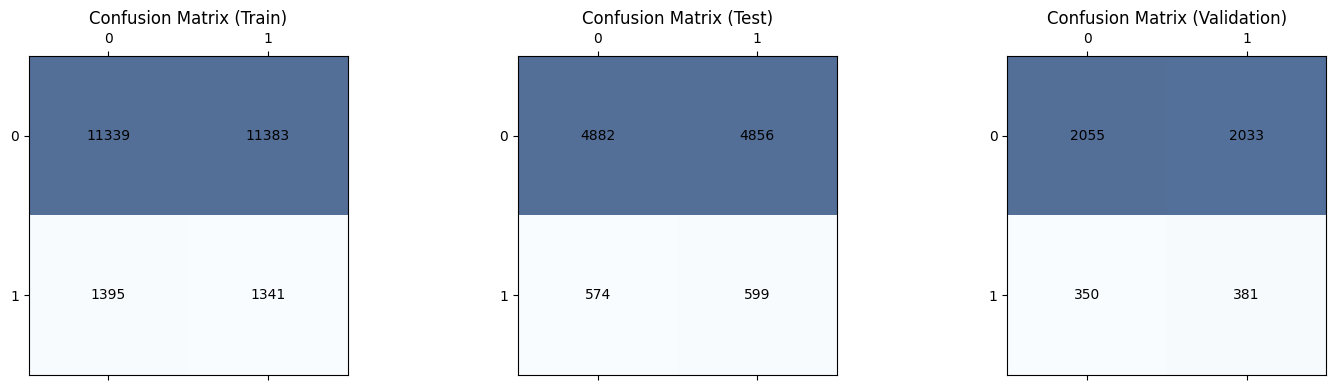

In [134]:
dummy_clf = DummyClassifier(strategy='uniform', random_state=42)
dummy_clf.fit(X_train1, y_train)
metrics_df = calculate_and_display_metrics(dummy_clf, X_train1, y_train, X_test1, y_test, X_val1, y_val)

Com base nos seus resultados, fica evidente que seu desempenho está abaixo do ideal em todas as métricas avaliadas pois ele atribui classes aleatoriamente, respeitando a distribuição das classes no conjunto de treinamento.

Para futuras comparações, qualquer modelo que supere esses valores indicará uma melhoria significativa na capacidade de previsão.

## 4. BALANCEAMENTO

No objetivo de identificar quais clientes possuem maior propensão à conversão nessa campanha de marketing, estamos lidando com dados desbalanceados, onde aproximadamente 11% dos clientes convertem.

Utilizar esses dados desbalanceados sem um balanceamento pode levar a um modelo tendencioso que favorece a classe majoritária (clientes que não convertem), resultando em previsões imprecisas e subótimas.

Para mitigar o desbalanceamento de classes, iremos considerar várias técnicas:

- **Class Weight**: Ajusta a importância de cada classe durante o treinamento do modelo sem alterar o conjunto de dados original.
- **Oversampling**: Duplica ou cria novos exemplos da classe minoritária para aumentar seu número no conjunto de dados.
- **Undersampling**: Remove exemplos da classe majoritária para equilibrar a proporção de classes.
- **SMOTENC (SMOTE for Nominal and Continuous features)**:  Gera exemplos sintéticos da classe minoritária interpolando entre exemplos existentes e lida com dados mistos (numéricos e categóricos).
- **ADASYN (Adaptive Synthetic Sampling)**: Gera exemplos sintéticos de forma adaptativa, focando em regiões onde a classe minoritária é mais difícil de aprender.
- **KMeans SMOTE**: Combina clustering K-Means com SMOTE para gerar exemplos sintéticos mais representativos.

Escolher a técnica adequada depende das características dos dados e dos objetivos da campanha. Experimentar e comparar diferentes métodos ajudará a determinar a melhor abordagem para melhorar a precisão das previsões e a eficácia da campanha.

### 4.1 CLASS WEIGHT

Usando o parâmetro `class_weight` quando disponível (para o XGBoost, utilizando `scale_pos_weight`.

In [135]:
#inicializando os modelos a serem testados
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42, n_jobs=-1),
    'Decision Tree (depth=10)': DecisionTreeClassifier(max_depth=10, class_weight='balanced', random_state=42),
    'Decision Tree (no depth)': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'Random Forest (depth=10)': RandomForestClassifier(max_depth=10, class_weight='balanced', random_state=42, n_jobs=-1),
    'Random Forest (no depth)': RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(scale_pos_weight=8.09, random_state=42, n_jobs=-1), #scale_pos_weight = #no/#yes = 89/11
}

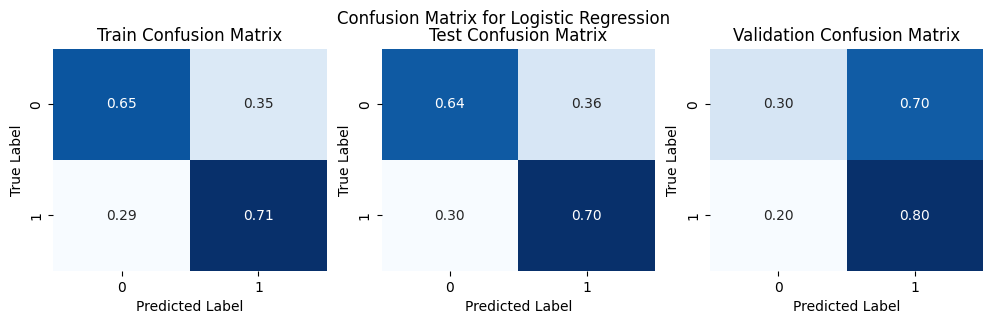

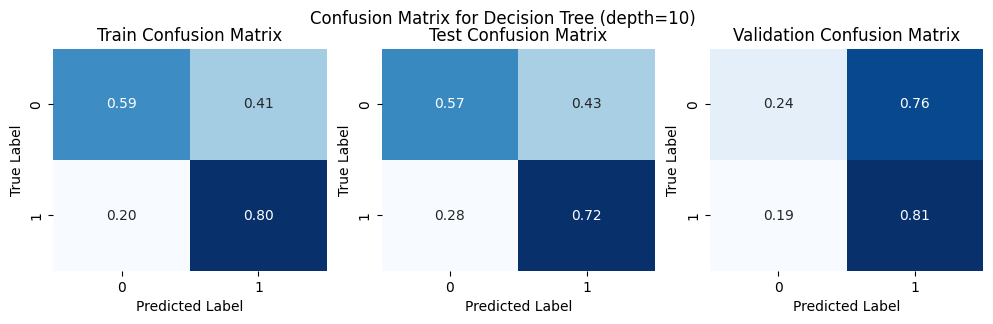

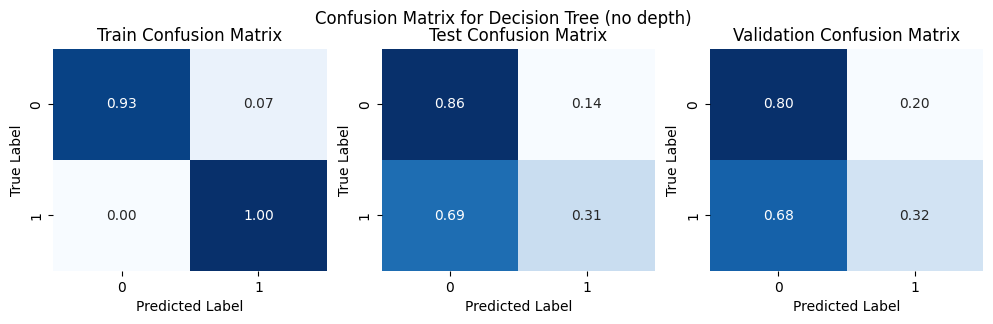

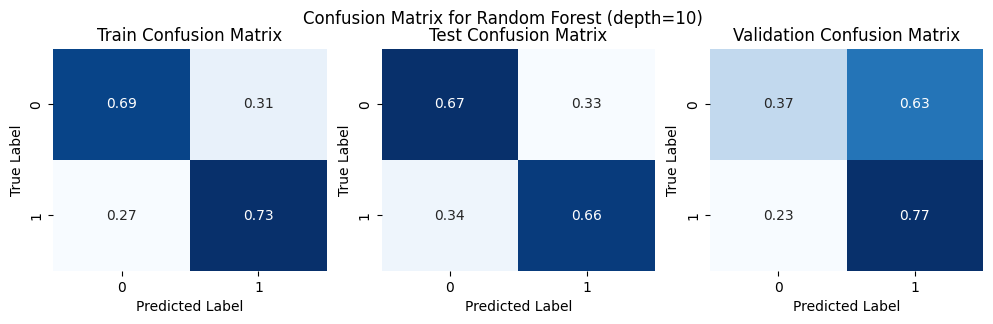

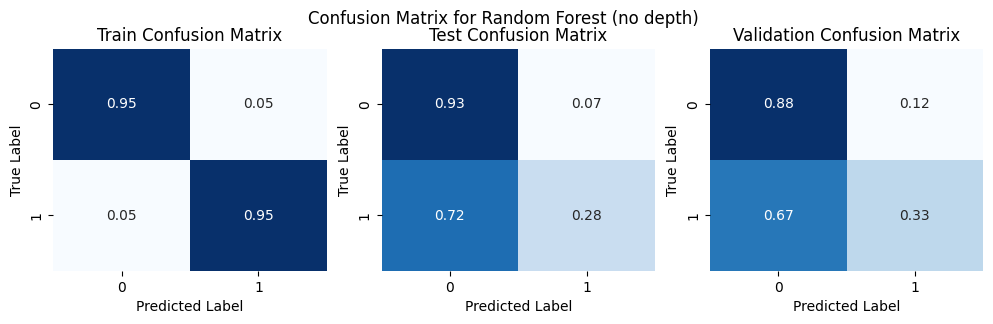

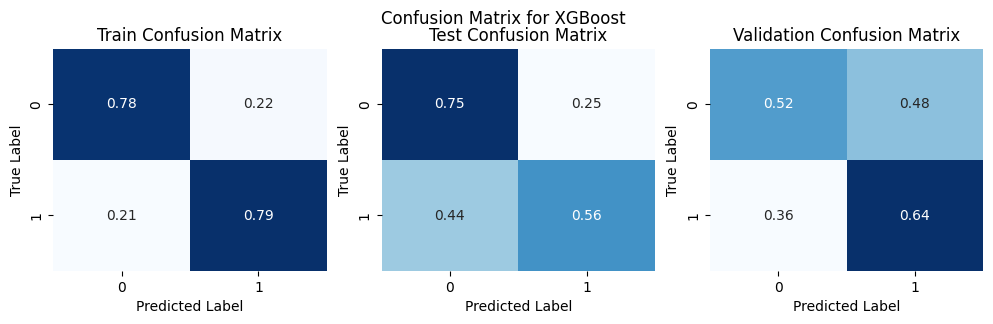

In [136]:
modelos_cw = evaluate_models(X_train1, X_test1, X_val1, y_train, y_test, y_val, models)

In [137]:
display(modelos_cw)

,Model,Training Time (s),Train Accuracy,Test Accuracy,Val Accuracy,Train F1,Test F1,Val F1,Train AUC,Test AUC,Val AUC,Train Precision,Test Precision,Val Precision,Train Recall,Test Recall,Val Recall
0,Logistic Regression,1.115867,0.653272,0.643846,0.377672,0.304468,0.297542,0.280298,0.676523,0.669253,0.550627,0.194073,0.188805,0.169965,0.706140,0.701620,0.798906
1,Decision Tree (depth=10),0.068031,0.608885,0.587297,0.330982,0.305794,0.273827,0.269597,0.693611,0.647321,0.529286,0.188938,0.168854,0.161553,0.801535,0.723785,0.813953
2,Decision Tree (no depth),0.115200,0.938408,0.804051,0.722972,0.776956,0.252448,0.257921,0.964692,0.585795,0.556436,0.636004,0.213989,0.217228,0.998173,0.307758,0.317373
3,Random Forest (depth=10),1.438183,0.697148,0.672624,0.431417,0.340575,0.302071,0.291990,0.710587,0.666630,0.571633,0.222309,0.195944,0.179994,0.727705,0.658994,0.772914
4,Random Forest (no depth),2.610955,0.952431,0.856475,0.794148,0.811635,0.292043,0.327001,0.952937,0.600918,0.603443,0.706472,0.310876,0.324361,0.953582,0.275362,0.329685
5,XGBoost,0.330879,0.781444,0.726515,0.539116,0.436842,0.306047,0.295144,0.784654,0.653706,0.578943,0.302072,0.210425,0.192149,0.788743,0.560955,0.636115


### 4.2 OVERSAMPLING

In [138]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, n_jobs=-1),
    'K-Nearest Neighbors': KNeighborsClassifier(n_jobs=-1),
    'Decision Tree (depth=10)': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Decision Tree (no depth)': DecisionTreeClassifier(random_state=42),
    'Random Forest (depth=10)': RandomForestClassifier(max_depth=10, random_state=42, n_jobs=-1),
    'Random Forest (no depth)': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=42, n_jobs=-1),
    'Multi Layer Perceptron Neural Network': MLPClassifier(random_state=42)
}


In [139]:
ros = RandomOverSampler(random_state=42)
X_train1_resampled, y_train_resampled = ros.fit_resample(X_train1, y_train)

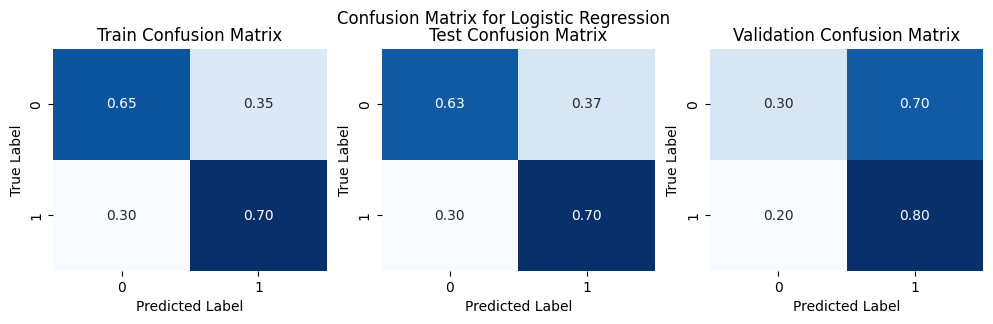

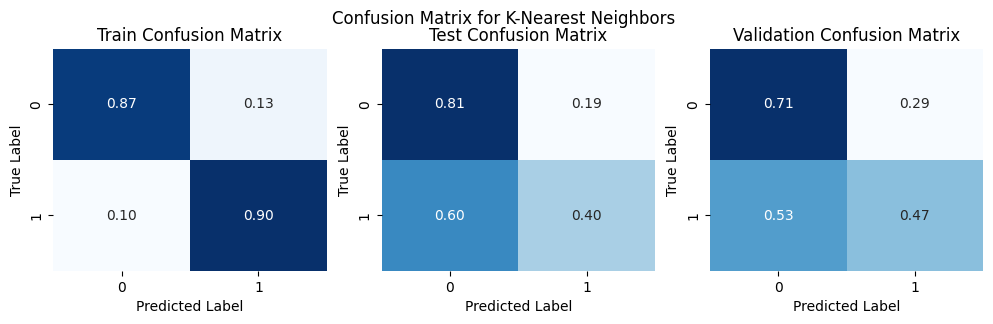

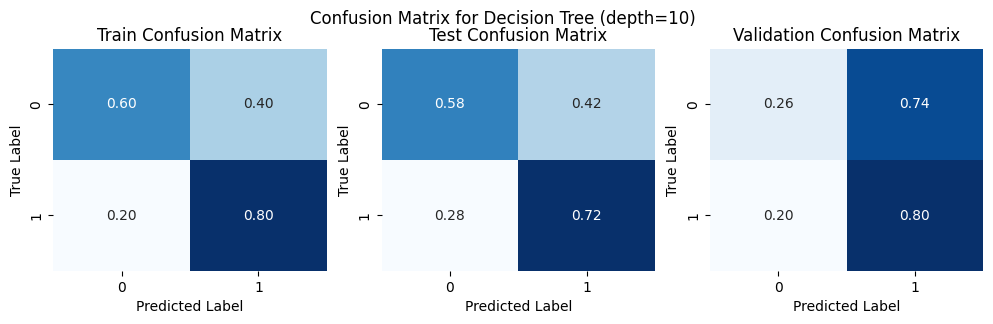

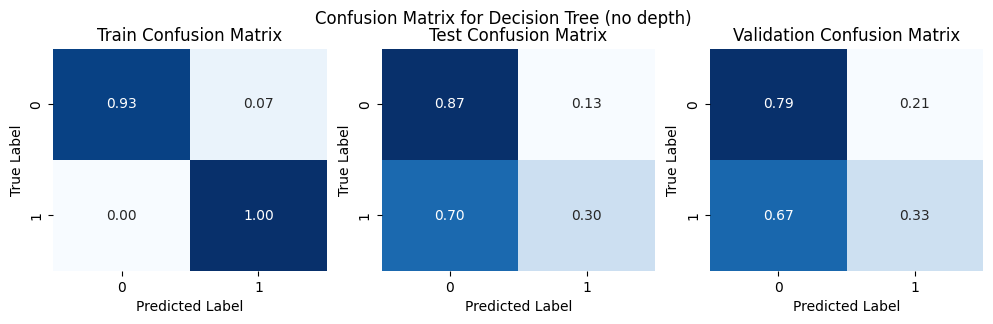

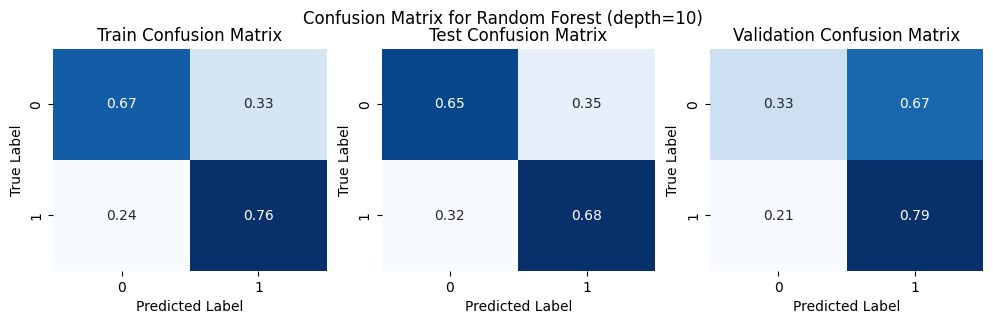

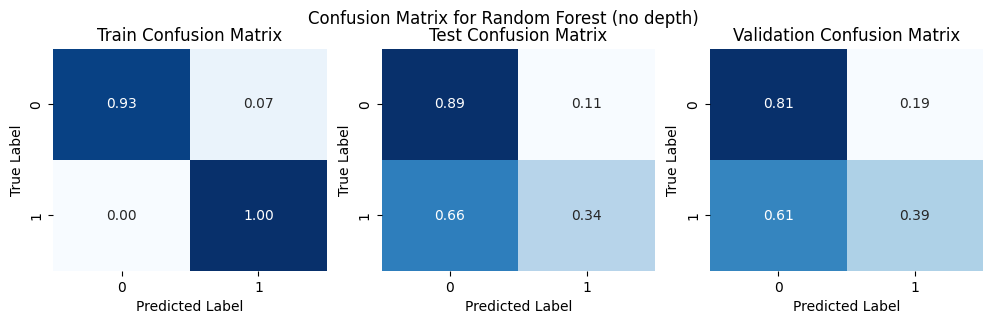

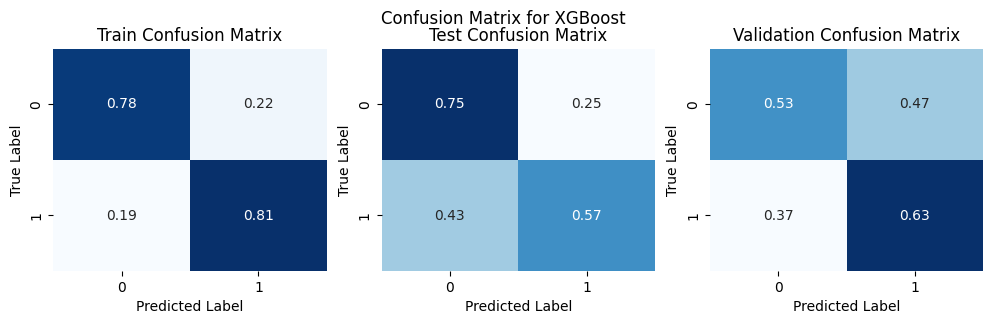

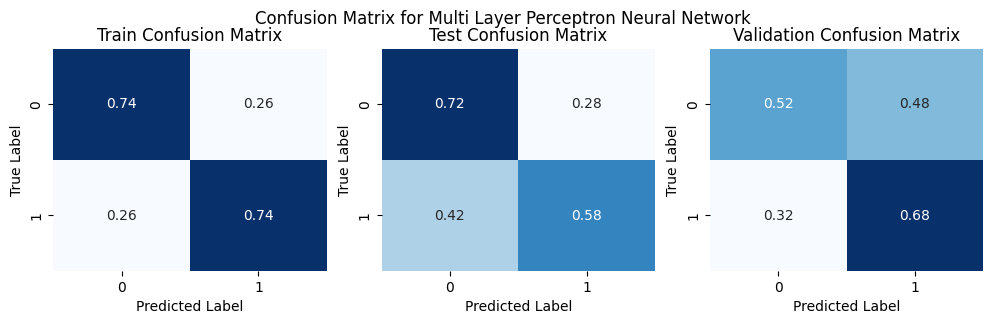

In [140]:
modelos_os = evaluate_models(X_train1_resampled, X_test1, X_val1, y_train_resampled, y_test, y_val, models)

In [141]:
display(modelos_os)

,Model,Training Time (s),Train Accuracy,Test Accuracy,Val Accuracy,Train F1,Test F1,Val F1,Train AUC,Test AUC,Val AUC,Train Precision,Test Precision,Val Precision,Train Recall,Test Recall,Val Recall
0,Logistic Regression,0.864338,0.674875,0.641829,0.375389,0.684099,0.295856,0.279904,0.674875,0.667374,0.549843,0.665225,0.187571,0.169614,0.704075,0.699915,0.800274
1,K-Nearest Neighbors,0.015246,0.884913,0.762258,0.671716,0.886934,0.266817,0.301853,0.884913,0.603997,0.588011,0.871633,0.199577,0.222801,0.902781,0.402387,0.467852
2,Decision Tree (depth=10),0.100632,0.700709,0.596004,0.341565,0.727909,0.275953,0.270071,0.700709,0.648824,0.531030,0.667266,0.170905,0.162334,0.800678,0.716113,0.803010
3,Decision Tree (no depth),0.262721,0.964924,0.804784,0.723179,0.965979,0.246285,0.266227,0.964924,0.581332,0.562175,0.937759,0.210526,0.222631,0.995951,0.296675,0.331053
4,Random Forest (depth=10),2.828913,0.713648,0.653836,0.401121,0.725817,0.297041,0.287055,0.713648,0.665477,0.562763,0.696229,0.190000,0.175158,0.758032,0.680307,0.794802
5,Random Forest (no depth),2.663948,0.964924,0.831454,0.749533,0.966019,0.305251,0.320765,0.964924,0.617269,0.601861,0.936782,0.274084,0.272467,0.997139,0.344416,0.389877
6,XGBoost,0.544150,0.796519,0.731922,0.549699,0.799149,0.312896,0.299548,0.796519,0.659735,0.584619,0.788952,0.215953,0.196029,0.809612,0.567775,0.634747
7,Multi Layer Perceptron Neural Network,69.453625,0.742980,0.703877,0.543266,0.743082,0.295311,0.311111,0.742980,0.648147,0.599363,0.742788,0.198417,0.201705,0.743376,0.577153,0.679891


### 4.3 UNDERSAMPLING

In [142]:
rus = RandomOverSampler(random_state=42)
X_train1_resampled, y_train_resampled = rus.fit_resample(X_train1, y_train)

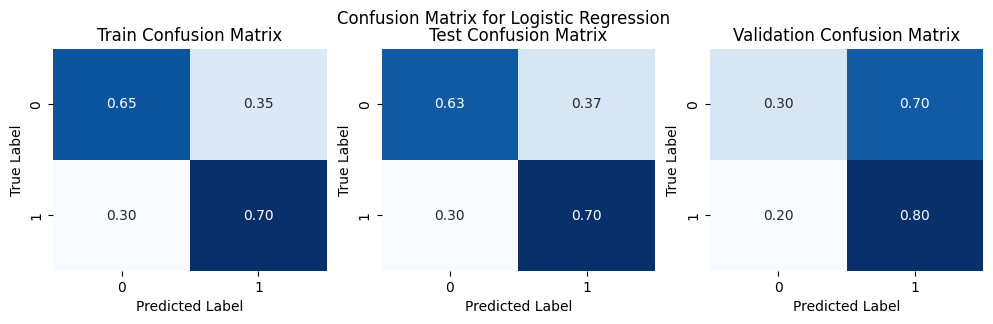

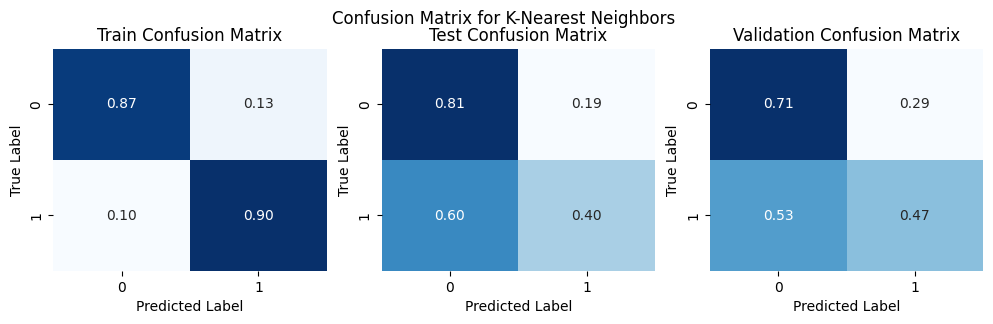

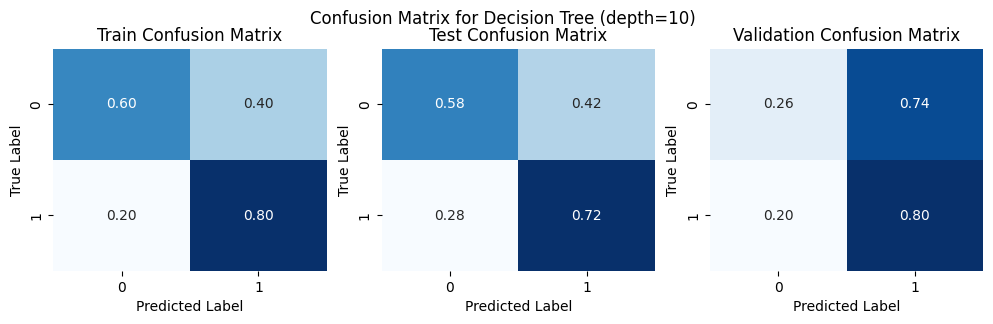

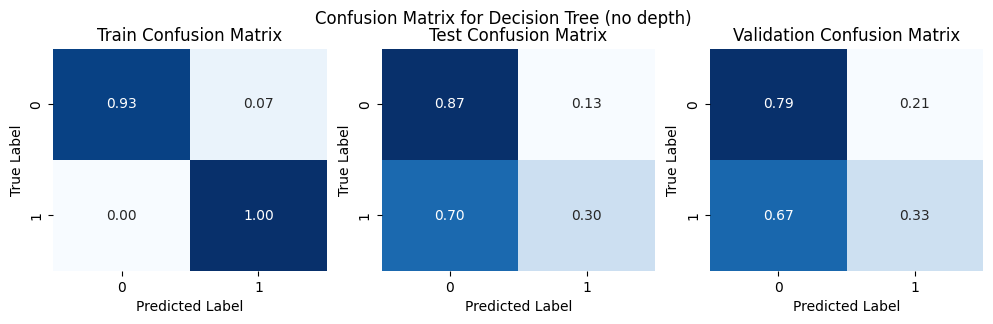

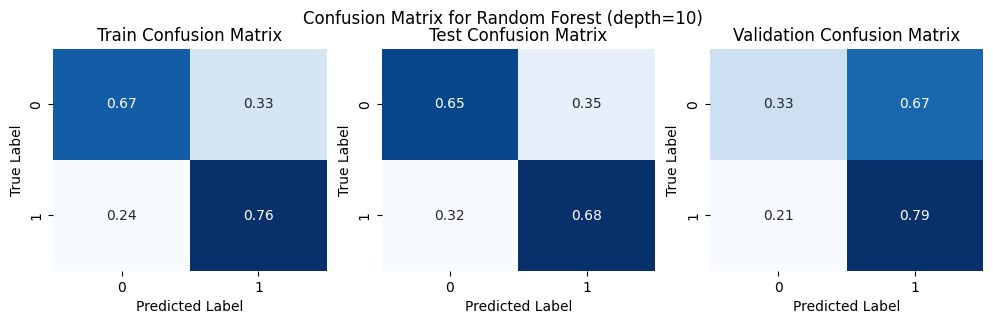

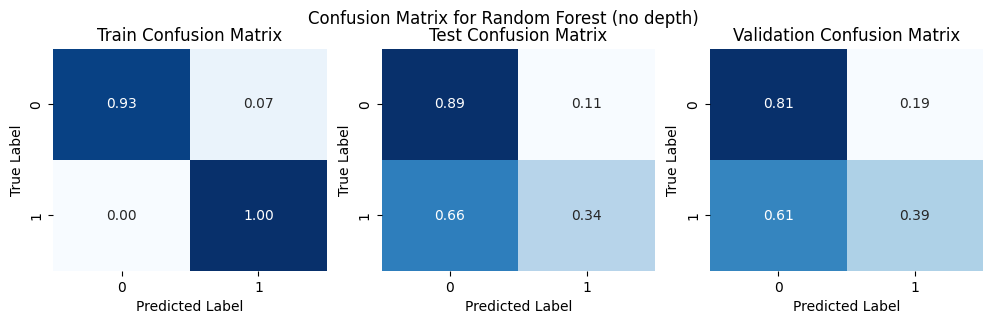

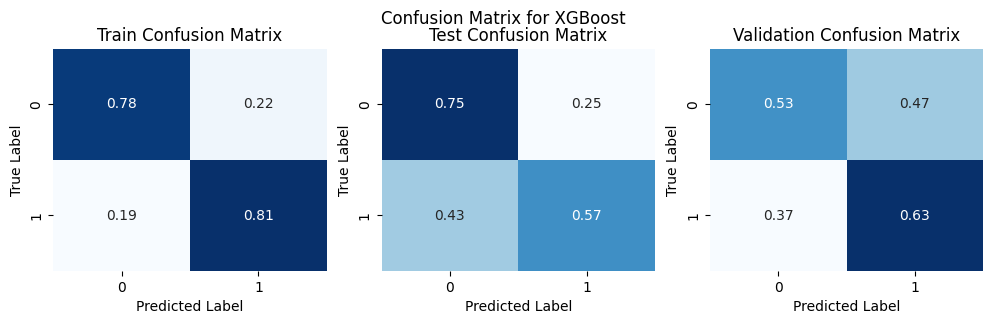

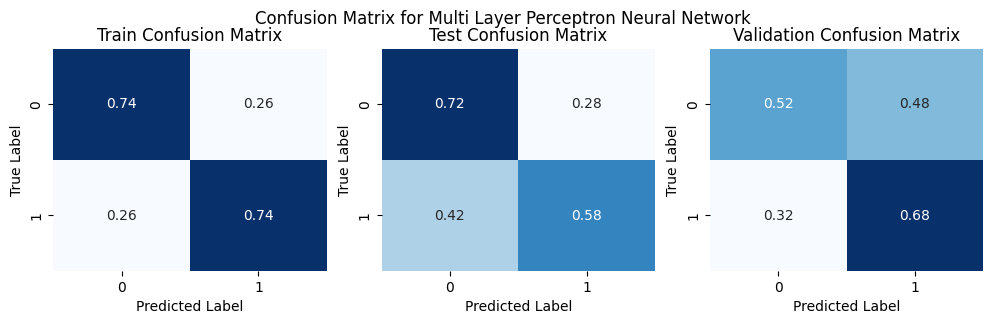

In [143]:
modelos_us = evaluate_models(X_train1_resampled, X_test1, X_val1, y_train_resampled, y_test, y_val, models)

In [144]:
display(modelos_us)

,Model,Training Time (s),Train Accuracy,Test Accuracy,Val Accuracy,Train F1,Test F1,Val F1,Train AUC,Test AUC,Val AUC,Train Precision,Test Precision,Val Precision,Train Recall,Test Recall,Val Recall
0,Logistic Regression,1.361650,0.674875,0.641829,0.375389,0.684099,0.295856,0.279904,0.674875,0.667374,0.549843,0.665225,0.187571,0.169614,0.704075,0.699915,0.800274
1,K-Nearest Neighbors,0.015029,0.884913,0.762258,0.671716,0.886934,0.266817,0.301853,0.884913,0.603997,0.588011,0.871633,0.199577,0.222801,0.902781,0.402387,0.467852
2,Decision Tree (depth=10),0.098489,0.700709,0.596004,0.341565,0.727909,0.275953,0.270071,0.700709,0.648824,0.531030,0.667266,0.170905,0.162334,0.800678,0.716113,0.803010
3,Decision Tree (no depth),0.164971,0.964924,0.804784,0.723179,0.965979,0.246285,0.266227,0.964924,0.581332,0.562175,0.937759,0.210526,0.222631,0.995951,0.296675,0.331053
4,Random Forest (depth=10),2.097601,0.713648,0.653836,0.401121,0.725817,0.297041,0.287055,0.713648,0.665477,0.562763,0.696229,0.190000,0.175158,0.758032,0.680307,0.794802
5,Random Forest (no depth),3.226773,0.964924,0.831454,0.749533,0.966019,0.305251,0.320765,0.964924,0.617269,0.601861,0.936782,0.274084,0.272467,0.997139,0.344416,0.389877
6,XGBoost,0.509523,0.796519,0.731922,0.549699,0.799149,0.312896,0.299548,0.796519,0.659735,0.584619,0.788952,0.215953,0.196029,0.809612,0.567775,0.634747
7,Multi Layer Perceptron Neural Network,67.101634,0.742980,0.703877,0.543266,0.743082,0.295311,0.311111,0.742980,0.648147,0.599363,0.742788,0.198417,0.201705,0.743376,0.577153,0.679891


### 4.4 SMOTENC

In [145]:
categorical_features = ['education',
'default',
'housing',
'loan',
'job_admin.',
'job_blue-collar',
'job_entrepreneur',
'job_housemaid',
'job_management',
'job_retired',
'job_self-employed',
'job_services',
'job_student',
'job_technician',
'job_unemployed',
'marital_divorced',
'marital_married',
'marital_single',
'contact_cellular',
'contact_telephone',
'poutcome_failure',
'poutcome_success']
categorical_indices = [X_train1.columns.get_loc(col) for col in categorical_features]
smotenc = SMOTENC(categorical_features=categorical_indices, random_state=42)
X_train1_resampled, y_train_resampled = smotenc.fit_resample(X_train1, y_train)

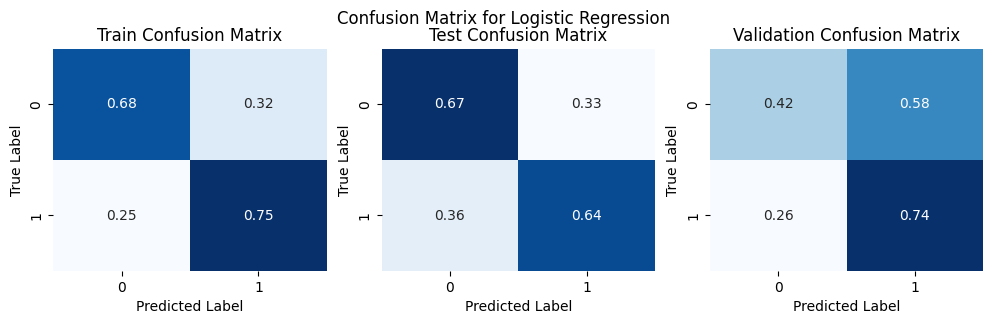

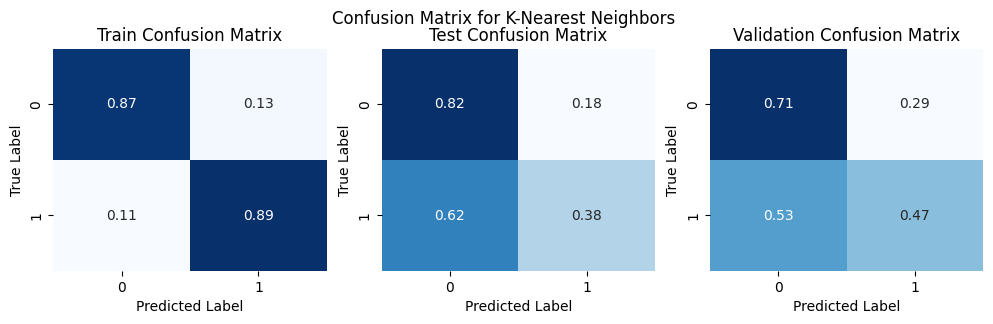

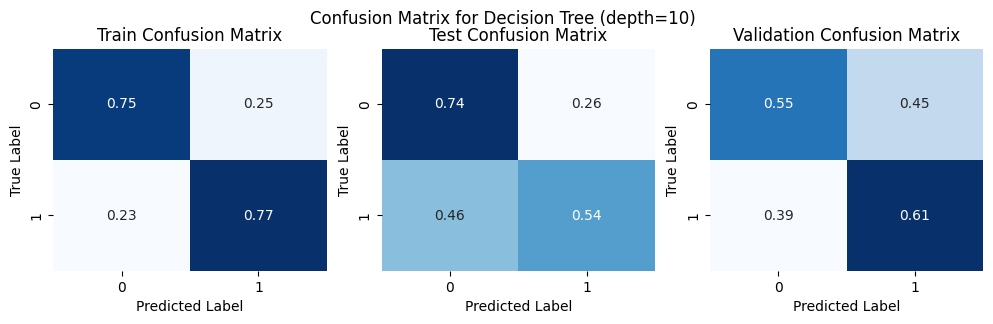

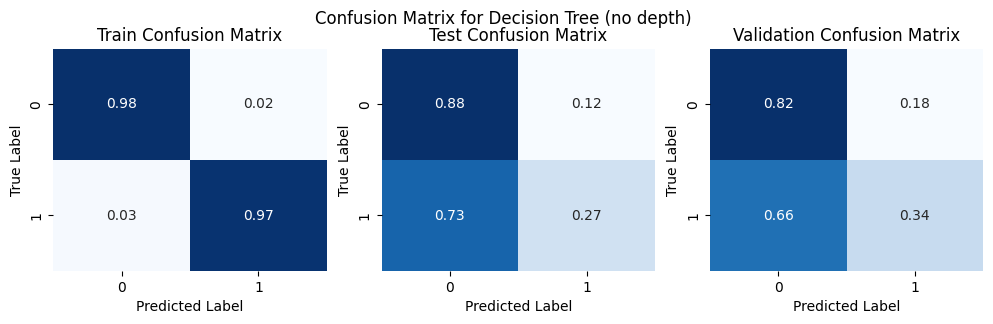

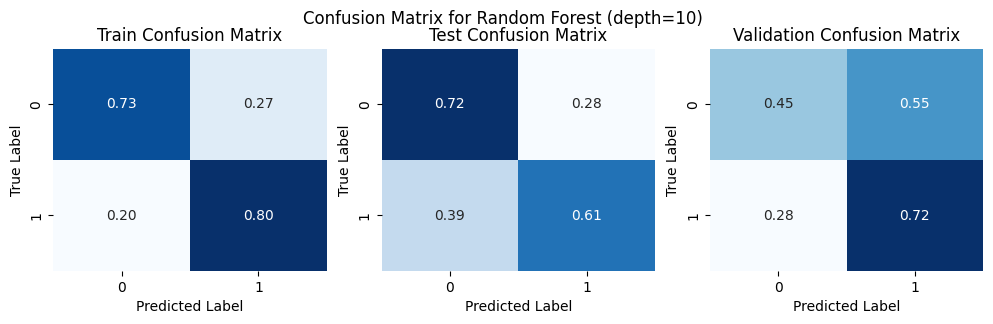

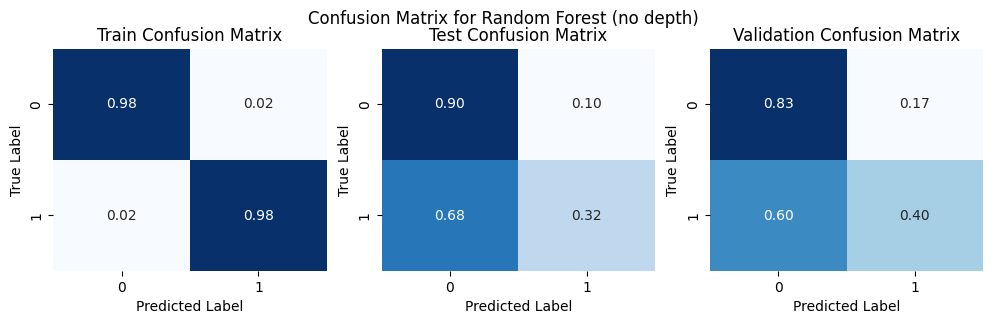

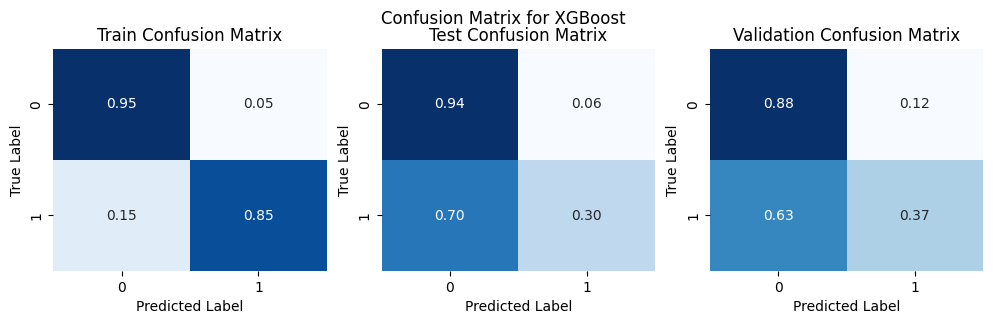

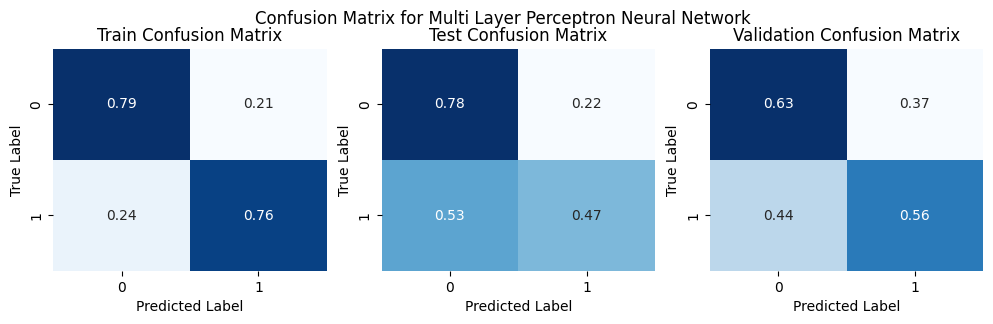

In [146]:
modelos_smotenc = evaluate_models(X_train1_resampled, X_test1, X_val1, y_train_resampled, y_test, y_val, models)

In [147]:
display(modelos_smotenc)

,Model,Training Time (s),Train Accuracy,Test Accuracy,Val Accuracy,Train F1,Test F1,Val F1,Train AUC,Test AUC,Val AUC,Train Precision,Test Precision,Val Precision,Train Recall,Test Recall,Val Recall
0,Logistic Regression,1.553388,0.716068,0.670883,0.468354,0.724912,0.294360,0.296540,0.716068,0.656656,0.579362,0.703015,0.191267,0.185503,0.748218,0.638534,0.738714
1,K-Nearest Neighbors,0.015132,0.880072,0.772157,0.673584,0.881150,0.263189,0.303674,0.880072,0.599045,0.589674,0.873303,0.201726,0.224476,0.889138,0.378517,0.469220
2,Decision Tree (depth=10),0.127063,0.762653,0.716708,0.563395,0.765512,0.288935,0.299134,0.762653,0.636965,0.584266,0.756401,0.197858,0.197710,0.774844,0.535379,0.614227
3,Decision Tree (no depth),0.196918,0.977291,0.814866,0.743723,0.977127,0.241172,0.288184,0.977291,0.576857,0.578777,0.984238,0.215581,0.249004,0.970117,0.273657,0.341997
4,Random Forest (depth=10),1.820368,0.767516,0.704977,0.492426,0.775599,0.306399,0.300343,0.767516,0.661510,0.585125,0.749538,0.205017,0.189873,0.803538,0.606138,0.718194
5,Random Forest (no depth),5.299919,0.977269,0.838237,0.767794,0.977278,0.297093,0.342924,0.977269,0.609446,0.616556,0.976870,0.278774,0.300412,0.977687,0.317988,0.399453
6,XGBoost,0.575208,0.898777,0.869581,0.803279,0.893157,0.330983,0.364611,0.898777,0.619133,0.626237,0.945652,0.368973,0.357424,0.846184,0.300085,0.372093
7,Multi Layer Perceptron Neural Network,70.648069,0.774954,0.747044,0.620046,0.770546,0.287190,0.307750,0.774954,0.626966,0.594066,0.785940,0.206002,0.212644,0.755743,0.473998,0.556772


### 4.5 ADASYN

In [148]:
ada = ADASYN(random_state=42)
X_train1_resampled, y_train_resampled = ada.fit_resample(X_train1, y_train)

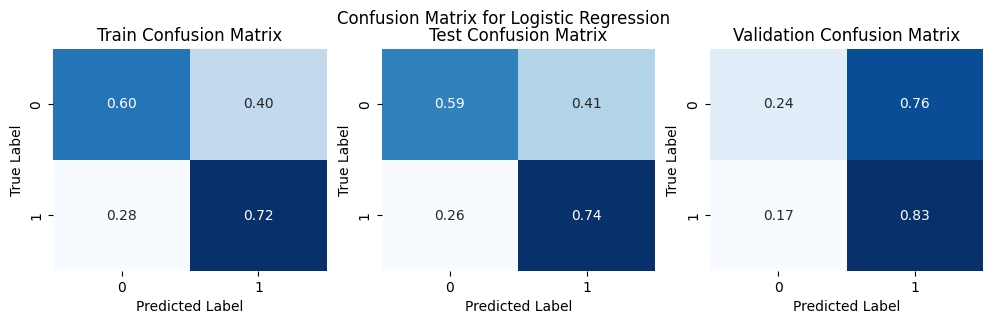

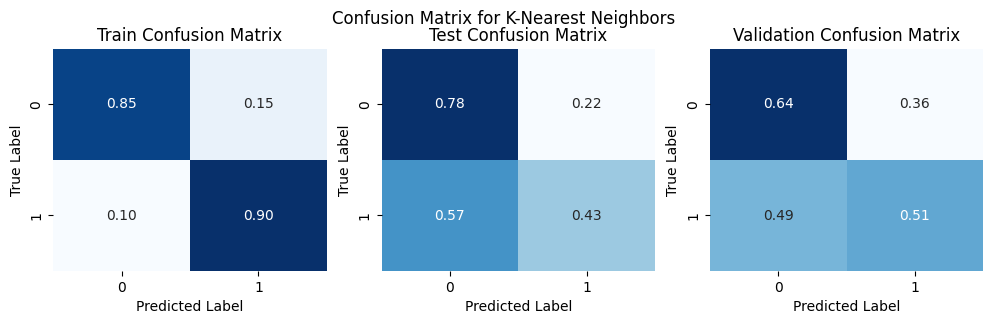

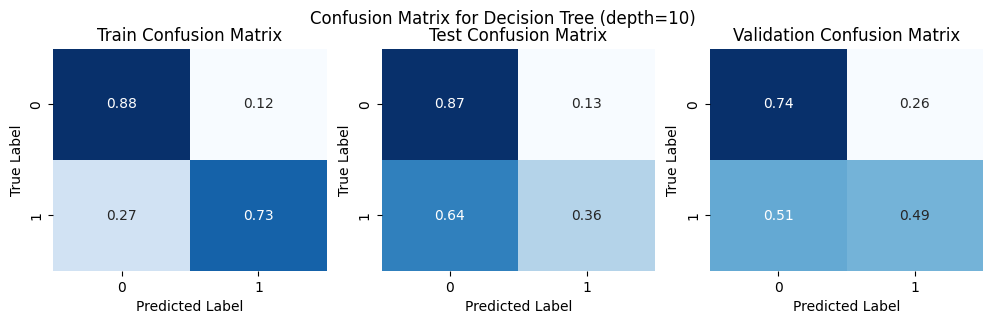

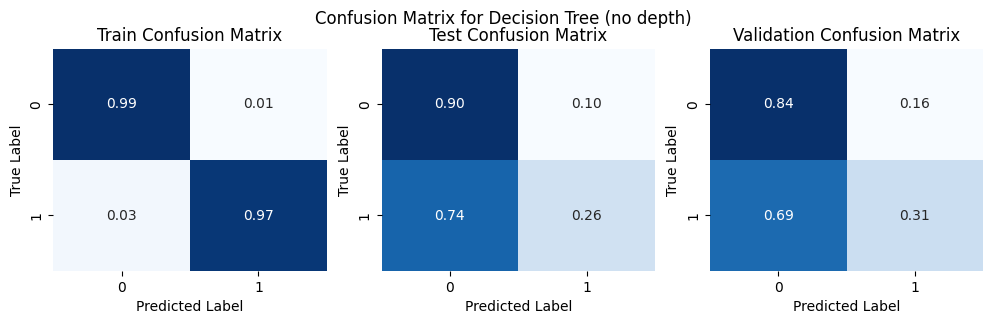

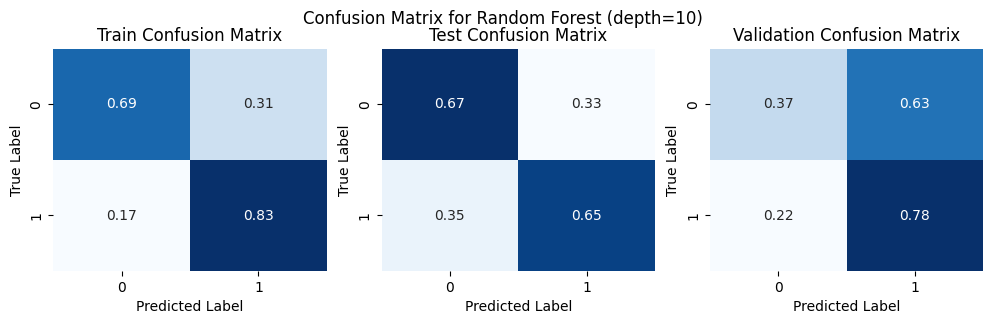

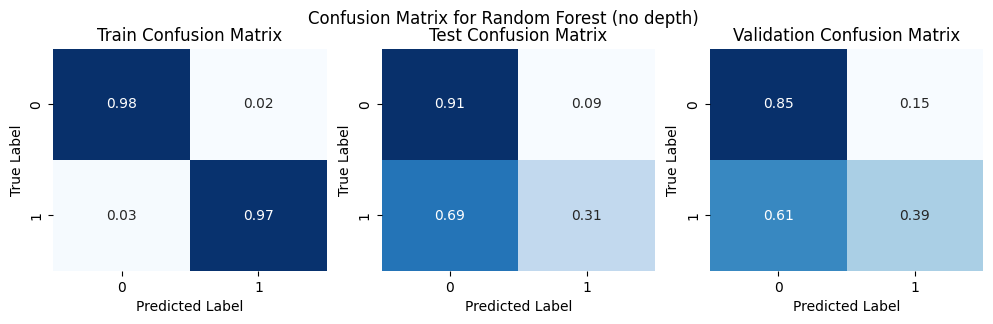

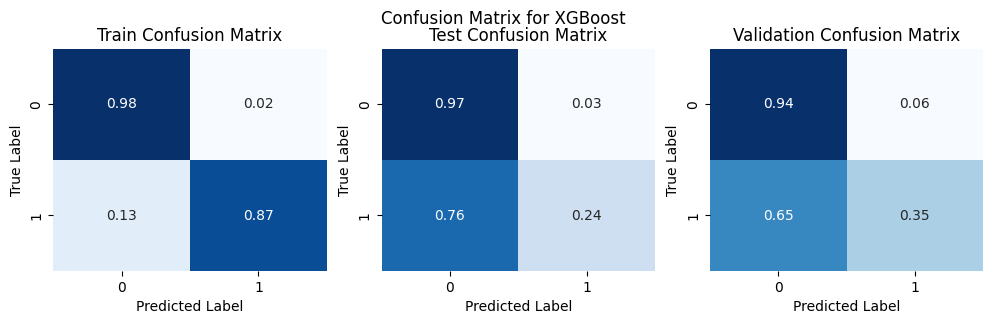

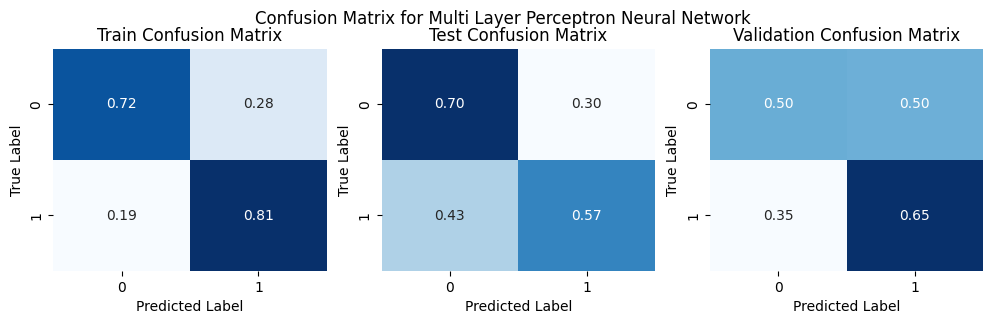

In [149]:
modelos_adasyn = evaluate_models(X_train1_resampled, X_test1, X_val1, y_train_resampled, y_test, y_val, models)

In [150]:
display(modelos_adasyn)

,Model,Training Time (s),Train Accuracy,Test Accuracy,Val Accuracy,Train F1,Test F1,Val F1,Train AUC,Test AUC,Val AUC,Train Precision,Test Precision,Val Precision,Train Recall,Test Recall,Val Recall
0,Logistic Regression,1.488506,0.663367,0.605444,0.332642,0.683372,0.286897,0.273385,0.662967,0.663861,0.535881,0.648967,0.178043,0.163735,0.721629,0.738278,0.827633
1,K-Nearest Neighbors,0.015221,0.875120,0.738337,0.624196,0.879314,0.262845,0.291194,0.874924,0.604468,0.576853,0.856203,0.188519,0.203947,0.903708,0.433930,0.508892
2,Decision Tree (depth=10),0.133041,0.804201,0.811566,0.700353,0.790005,0.290545,0.331481,0.804699,0.612500,0.613877,0.858526,0.244058,0.250525,0.731614,0.358909,0.489740
3,Decision Tree (no depth),0.205744,0.979391,0.832646,0.762399,0.979243,0.249795,0.284822,0.979485,0.580445,0.577428,0.993169,0.241079,0.262069,0.965703,0.259165,0.311902
4,Random Forest (depth=10),2.369713,0.760687,0.667950,0.427475,0.777511,0.295821,0.291292,0.760207,0.659512,0.570433,0.730769,0.191591,0.179317,0.830642,0.648764,0.775650
5,Random Forest (no depth),4.280906,0.979347,0.847768,0.779622,0.979378,0.301807,0.347666,0.979382,0.609537,0.618473,0.984599,0.297678,0.315496,0.974212,0.306053,0.387141
6,XGBoost,0.610945,0.925584,0.889928,0.853289,0.921938,0.315670,0.420966,0.925945,0.602413,0.647289,0.976779,0.475945,0.524490,0.872927,0.236147,0.351573
7,Multi Layer Perceptron Neural Network,70.885309,0.766348,0.685638,0.524590,0.777210,0.280922,0.293119,0.766051,0.635305,0.575998,0.747325,0.186266,0.189243,0.809586,0.571185,0.649795


### 4.6 KMEANS SMOTE

In [151]:
kmeans_sm = KMeansSMOTE(
    kmeans_estimator=MiniBatchKMeans(n_clusters=10, random_state=42),
    cluster_balance_threshold=0.1,
    random_state=42
)
X_train1_resampled, y_train_resampled = kmeans_sm.fit_resample(X_train1, y_train)

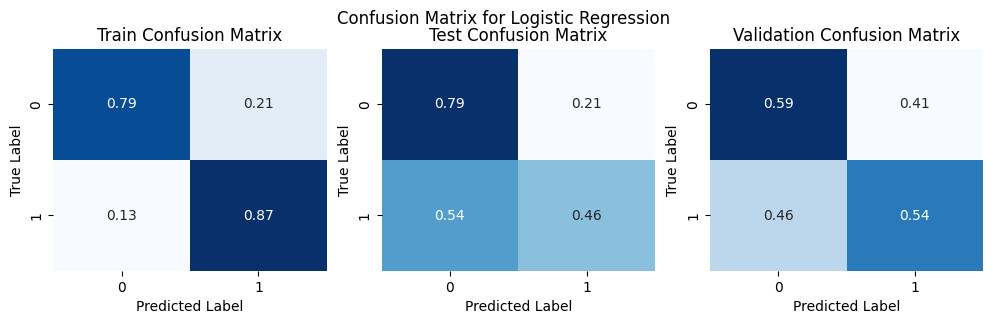

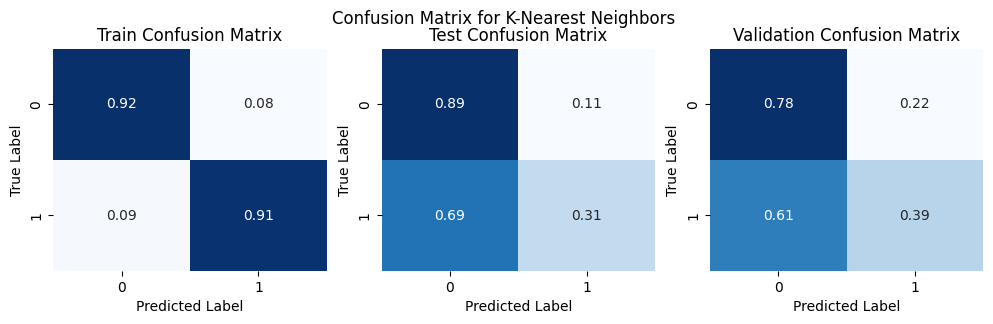

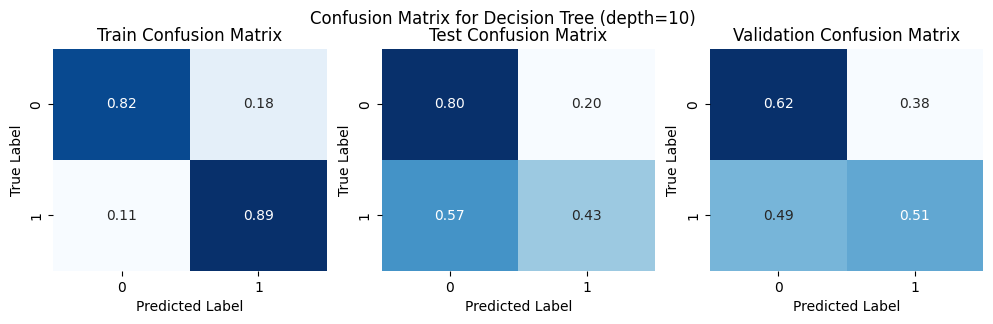

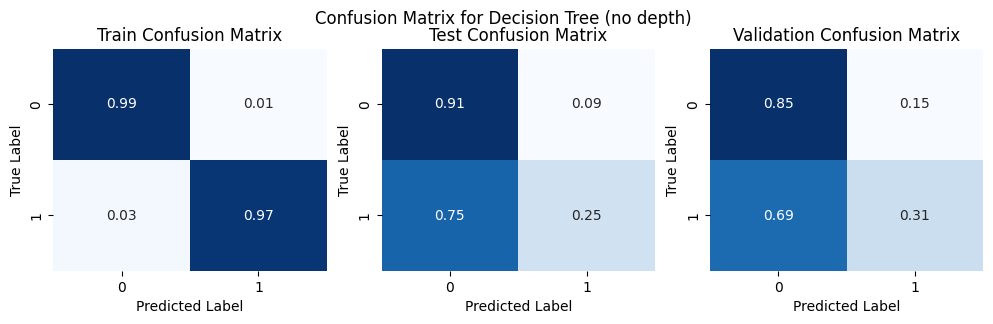

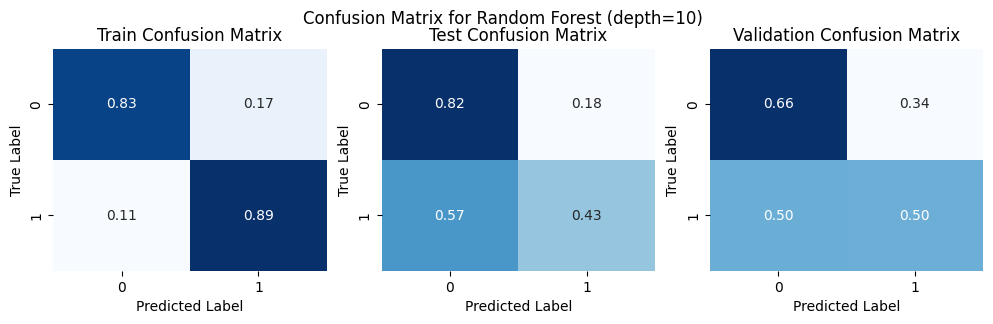

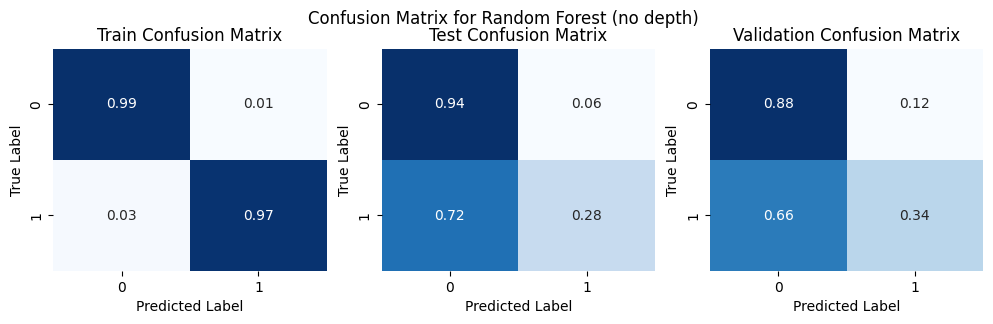

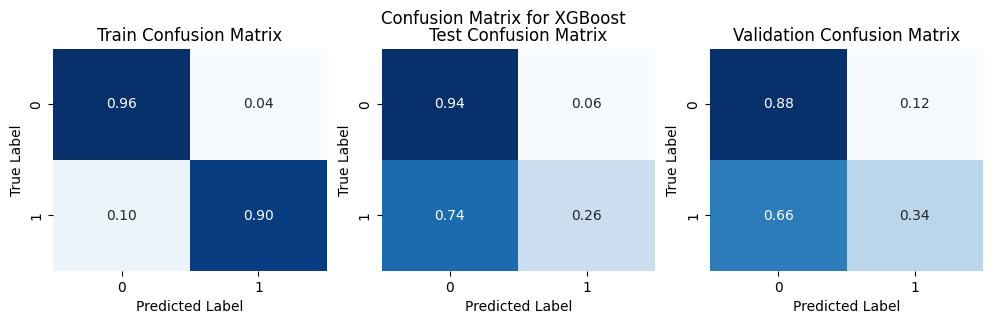

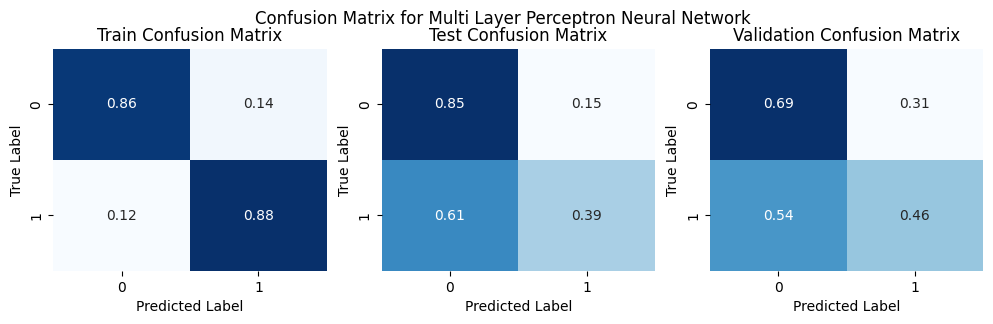

In [152]:
modelos_kmeans = evaluate_models(X_train1_resampled, X_test1, X_val1, y_train_resampled, y_test, y_val, models)

In [153]:
display(modelos_kmeans)

,Model,Training Time (s),Train Accuracy,Test Accuracy,Val Accuracy,Train F1,Test F1,Val F1,Train AUC,Test AUC,Val AUC,Train Precision,Test Precision,Val Precision,Train Recall,Test Recall,Val Recall
0,Logistic Regression,1.843964,0.833256,0.750985,0.579581,0.839660,0.282924,0.279516,0.833254,0.621676,0.562352,0.808656,0.204893,0.188852,0.873135,0.456948,0.537620
1,K-Nearest Neighbors,0.033939,0.916342,0.825131,0.723387,0.915818,0.275626,0.297312,0.916343,0.598354,0.584765,0.921654,0.248460,0.241852,0.910055,0.309463,0.385773
2,Decision Tree (depth=10),0.140666,0.853566,0.761525,0.606765,0.858756,0.278024,0.281380,0.853563,0.614459,0.566017,0.829411,0.206088,0.194648,0.890253,0.427110,0.507524
3,Decision Tree (no depth),0.209897,0.979911,0.838970,0.767794,0.979669,0.253294,0.287715,0.979911,0.581738,0.579485,0.991660,0.252542,0.269048,0.967965,0.254049,0.309166
4,Random Forest (depth=10),1.888988,0.860343,0.780772,0.632496,0.864215,0.298534,0.291883,0.860341,0.628240,0.577814,0.840953,0.227537,0.206215,0.888801,0.433930,0.499316
5,Random Forest (no depth),3.284106,0.979823,0.865915,0.797261,0.979702,0.310231,0.335826,0.979823,0.608456,0.608648,0.985658,0.347046,0.333784,0.973817,0.280477,0.337893
6,XGBoost,2.660030,0.929610,0.869398,0.798091,0.927692,0.300442,0.338545,0.929612,0.601784,0.610261,0.953755,0.354167,0.336486,0.903014,0.260870,0.340629
7,Multi Layer Perceptron Neural Network,66.877054,0.867582,0.797086,0.657398,0.869168,0.293103,0.288669,0.867581,0.618634,0.575640,0.858935,0.234303,0.210692,0.879648,0.391304,0.458276


### 4.7 RESULTADO




In [154]:
dataframes = {
    'Class Weight': modelos_cw,
    'Oversampling': modelos_os,
    'Undersampling': modelos_us,
    'SMOTENC': modelos_smotenc,
    'ADASYN': modelos_adasyn,
    'Kmeans SMOTE': modelos_kmeans
}

modified_dfs = []
for technique, df in dataframes.items():
    df_copy = df.copy()
    df_copy['Technique'] = technique
    modified_dfs.append(df_copy)

combined_df = pd.concat(modified_dfs, ignore_index=True)
combined_df.to_excel('balanceamento.xlsx', index=None)

Considerando os resultados obtidos para as métricas, F1 score, observa-se que o XGBoost com balanceamento por class weight foi o que performou melhor e apresentou boa estabilidade e menor possibilidade de overfitting. Sendo assim, utilizaremos esse modelo com esse balanceamento para os próximos testes.

## 5. VARIÁVEIS DERIVADAS

No objetivo de identificar o melhor conjunto de variáveis para o treinamento do modelo, iremos comparar o conjunto original com o conjunto com variáveis derivadas.

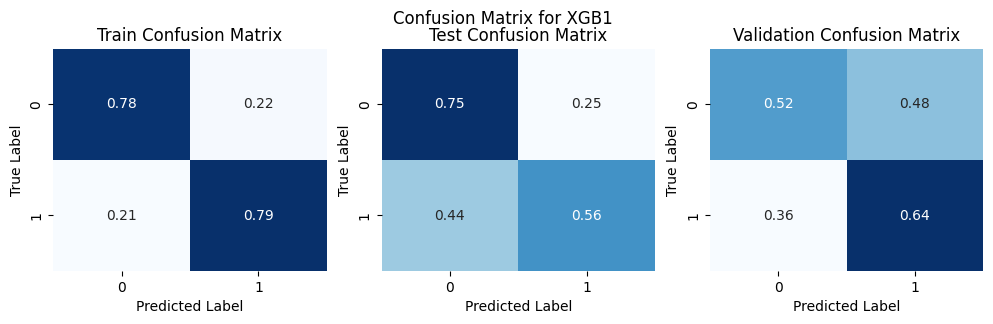

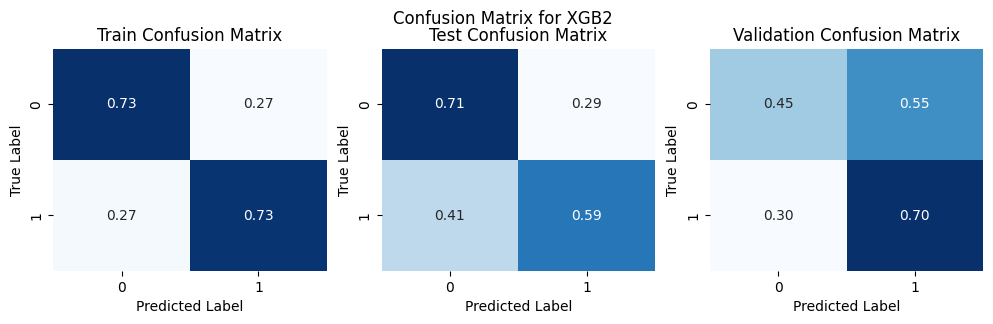

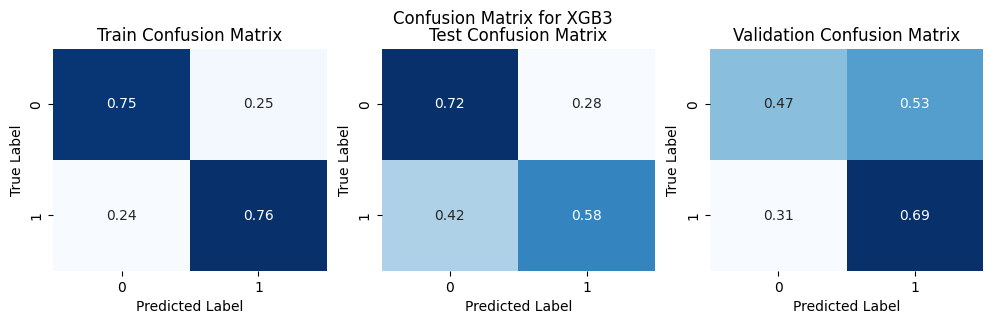

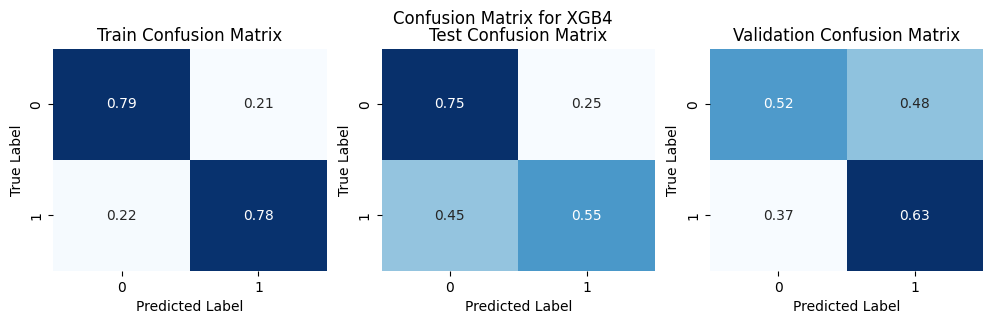

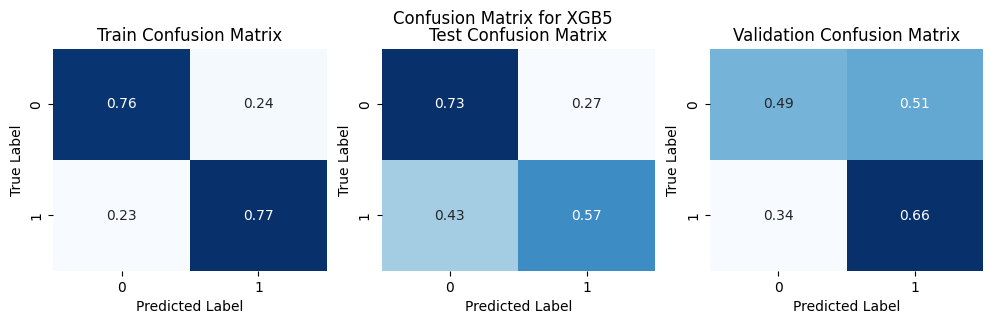

In [165]:
models = {
    'XGB1': XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=8.09).fit(X_train1, y_train),
    'XGB2': XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=8.09).fit(X_train2, y_train),
    'XGB3': XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=8.09).fit(X_train3, y_train),
    'XGB4': XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=8.09).fit(X_train4, y_train),
    'XGB5': XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=8.09).fit(X_train5, y_train)
}

y_train = np.ravel(y_train)

test_sets = [X_test1, X_test2, X_test3, X_test4, X_test5]
val_sets = [X_val1, X_val2, X_val3, X_val4, X_val5]

x_train_list = [X_train1, X_train2, X_train3, X_train4, X_train5]
y_tests = [np.ravel(y_test), np.ravel(y_test), np.ravel(y_test), np.ravel(y_test), np.ravel(y_test)]
y_vals = [np.ravel(y_val), np.ravel(y_val), np.ravel(y_val), np.ravel(y_val), np.ravel(y_val)]

plot_confusion_matrices(models, x_train_list, test_sets, val_sets, y_train, y_tests, y_vals)

De forma geral, os modelos tiveram um pequeno decréscimo de performance no f1 score quando usamos as variáveis derivadas, por isso iremos seguir com as variáveis originais.

## 6. REDUÇÃO DE DIMENSIONALIDADE

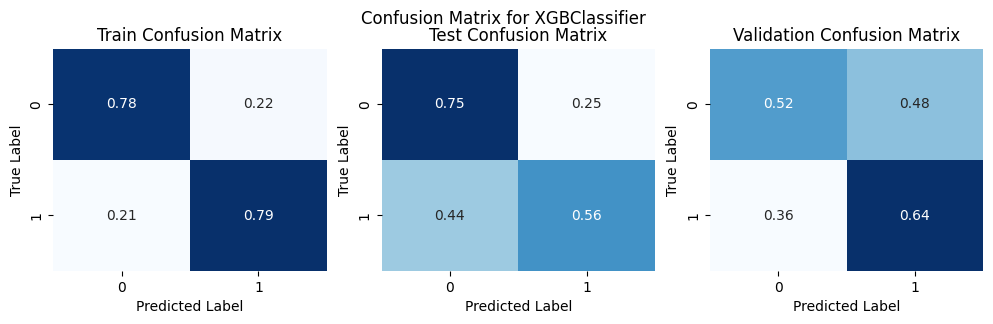

In [157]:
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)
y_val = np.ravel(y_val)

model = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=8.09)
model.fit(X_train1, y_train)

y_train_pred = model.predict(X_train1)
y_test_pred = model.predict(X_test1)
y_val_pred = model.predict(X_val1)

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
fig.suptitle('Confusion Matrix for XGBClassifier')
fig.subplots_adjust(top=0.85)

data_titles = [
    (y_train, y_train_pred, 'Train'),
    (y_test, y_test_pred, 'Test'),
    (y_val, y_val_pred, 'Validation')
]
titles = ['Train', 'Test', 'Validation']

for ax, (y_true, y_pred, title) in zip(axes, data_titles):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(f'{title} Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

plt.show()

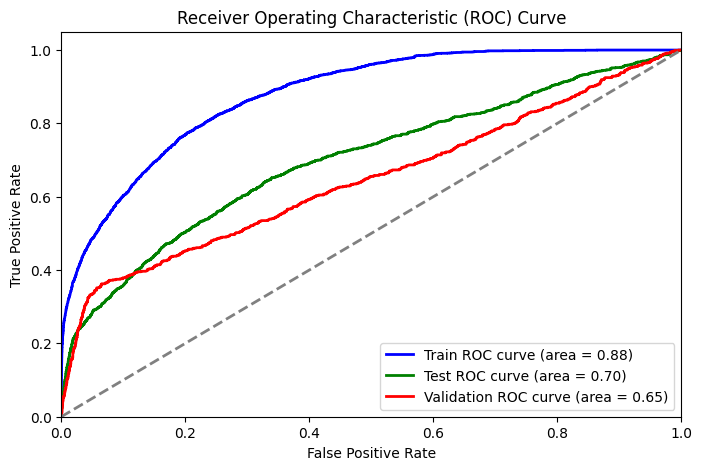

In [158]:
y_train_prob = model.predict_proba(X_train1)[:, 1]
y_test_prob = model.predict_proba(X_test1)[:, 1]
y_val_prob = model.predict_proba(X_val1)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

fpr_val, tpr_val, _ = roc_curve(y_val, y_val_prob)
roc_auc_val = auc(fpr_val, tpr_val)

plt.figure(figsize=(8, 5))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (area = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC curve (area = {roc_auc_test:.2f})')
plt.plot(fpr_val, tpr_val, color='red', lw=2, label=f'Validation ROC curve (area = {roc_auc_val:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### 6.1 SELECT FROM MODEL

In [159]:
#criando o classificador RandomForest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

#ajustando o modelo aos dados de treinamento
rf.fit(X_train1, y_train)

#aplicando SelectFromModel para selecionar características importantes
selector = SelectFromModel(rf, prefit=True, threshold='mean')
X_train_selected = selector.transform(X_train1)
X_test_selected = selector.transform(X_test1)
X_val_selected = selector.transform(X_val1)

#obtendo as características selecionadas
selected_features = X_train1.columns[(selector.get_support())]

#convertendo os dados selecionados de volta para DataFrames para facilitar o uso posterior
X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_features)
X_test_selected_df = pd.DataFrame(X_test_selected, columns=selected_features)
X_val_selected_df = pd.DataFrame(X_val_selected, columns=selected_features)

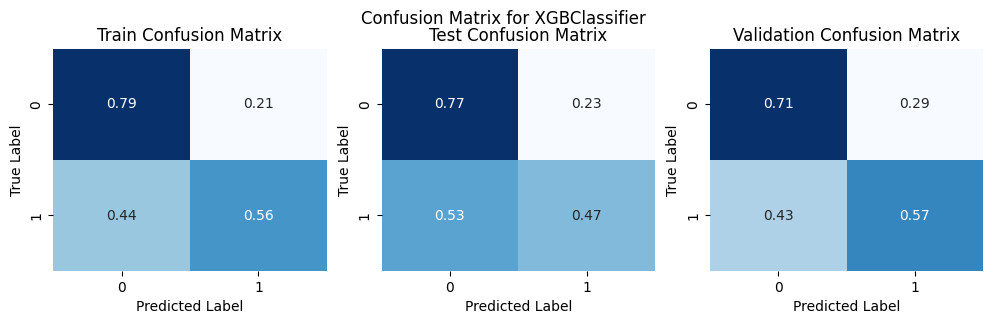

In [160]:
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)
y_val = np.ravel(y_val)

model = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=8.09)
model.fit(X_train_selected, y_train)

y_train_pred = model.predict(X_train_selected)
y_test_pred = model.predict(X_test_selected)
y_val_pred = model.predict(X_val_selected)

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
fig.suptitle('Confusion Matrix for XGBClassifier')
fig.subplots_adjust(top=0.85)

data_titles = [
    (y_train, y_train_pred, 'Train'),
    (y_test, y_test_pred, 'Test'),
    (y_val, y_val_pred, 'Validation')
]
titles = ['Train', 'Test', 'Validation']

for ax, (y_true, y_pred, title) in zip(axes, data_titles):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(f'{title} Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

plt.show()

### 6.2 RECURSIVE FEATURE ELIMINATION

In [166]:
#criando o classificador LogisticRegression
lr = LogisticRegression(max_iter=1000, random_state=42)

#criando o RFE com o classificador LogisticRegression
rfe = RFE(estimator=lr, n_features_to_select=10, step=1)

#ajustando o RFE aos dados de treinamento
rfe.fit(X_train1, y_train)

#aplicando a transformação aos conjuntos de dados
X_train_selected = rfe.transform(X_train1)
X_test_selected = rfe.transform(X_test1)
X_val_selected = rfe.transform(X_val1)

#obtendo as características selecionadas
selected_features = X_train1.columns[rfe.get_support()]

#convertendo os dados selecionados de volta para DataFrames para facilitar o uso posterior
X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_features)
X_test_selected_df = pd.DataFrame(X_test_selected, columns=selected_features)
X_val_selected_df = pd.DataFrame(X_val_selected, columns=selected_features)

In [167]:
selected_features

Index(['age', 'default', 'campaign', 'pdays', 'previous', 'job_retired',
       'job_student', 'contact_cellular', 'contact_telephone',
       'poutcome_success'],
      dtype='object')

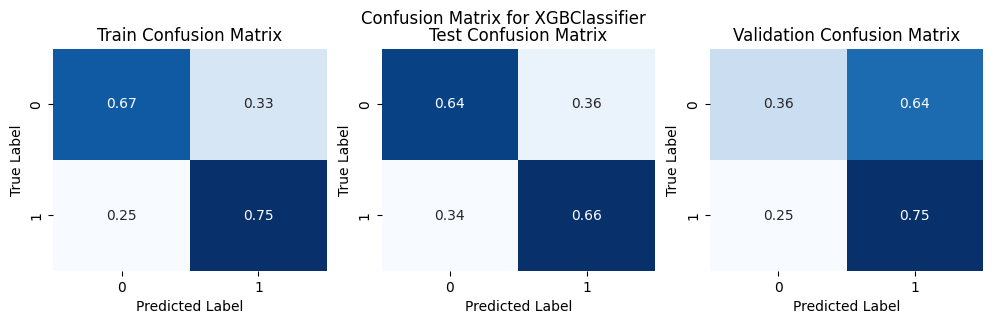

In [162]:
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)
y_val = np.ravel(y_val)

model = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=8.09)
model.fit(X_train_selected, y_train)

y_train_pred = model.predict(X_train_selected)
y_test_pred = model.predict(X_test_selected)
y_val_pred = model.predict(X_val_selected)

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
fig.suptitle('Confusion Matrix for XGBClassifier')
fig.subplots_adjust(top=0.85)

data_titles = [
    (y_train, y_train_pred, 'Train'),
    (y_test, y_test_pred, 'Test'),
    (y_val, y_val_pred, 'Validation')
]
titles = ['Train', 'Test', 'Validation']

for ax, (y_true, y_pred, title) in zip(axes, data_titles):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(f'{title} Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

plt.show()

### 6.3 PRINCIPAL COMPONENT ANALYSIS

In [163]:
#criando o PCA com 95% variância e ajustando aos dados de treinamento
pca = PCA(n_components=0.95, random_state=42)
X_train_selected = pca.fit_transform(X_train1)
X_test_selected = pca.transform(X_test1)
X_val_selected = pca.transform(X_val1)

#convertendo os dados transformados de volta para DataFrames para facilitar o uso posterior
pca_columns = [f'PC{i+1}' for i in range(pca.n_components_)]
X_train_selected_df = pd.DataFrame(X_train_selected, columns=pca_columns)
X_test_selected_df = pd.DataFrame(X_test_selected, columns=pca_columns)
X_val_selected_df = pd.DataFrame(X_val_selected, columns=pca_columns)

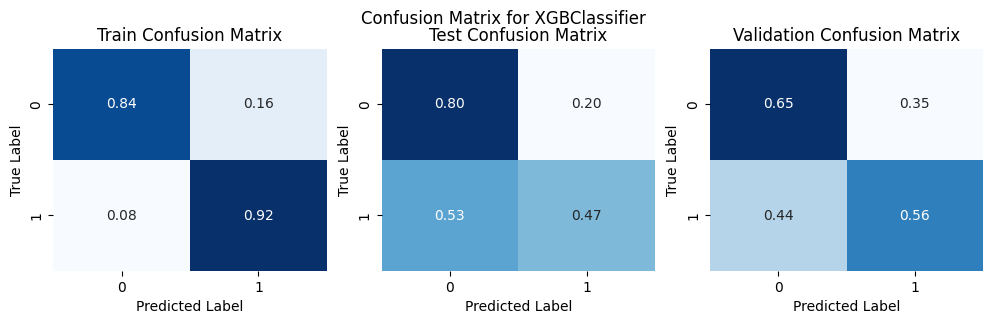

In [164]:
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)
y_val = np.ravel(y_val)

model = XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=8.09)
model.fit(X_train_selected, y_train)

y_train_pred = model.predict(X_train_selected)
y_test_pred = model.predict(X_test_selected)
y_val_pred = model.predict(X_val_selected)

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
fig.suptitle('Confusion Matrix for XGBClassifier')
fig.subplots_adjust(top=0.85)

data_titles = [
    (y_train, y_train_pred, 'Train'),
    (y_test, y_test_pred, 'Test'),
    (y_val, y_val_pred, 'Validation')
]
titles = ['Train', 'Test', 'Validation']

for ax, (y_true, y_pred, title) in zip(axes, data_titles):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(f'{title} Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

plt.show()

### 6.4 RESULTADO

Após a avaliação dos modelos com a redução de variáveis e dimensionalidade, constatamos que os melhores resultados foram obtidos com o conjunto de variáveis originais, sem nenhuma redução ou transformação. Nos próximos passos avaliaremos outra vez o uso de menos features usando a importância das features para o modelo